<h3 align="center"></h3>

<h3 align="center">Toronto Temperature Forecasting</h3>

### Group 1 – Applied Mathematical Concepts for Deep Learning

**Group Members:**  
Sepideh Forouzi        101599207
, Nate Sternberg           101620830
, Jeffrey Okoduwa        101477700
, Faimina Khokhani     101502974
, Sergio Medrano          1014466299
, Gordon Yeung          101624758


---
## Introduction

### This Project
Our project outlines a complete and reproducible workflow for **next-day forecasting of daily mean air temperature in Toronto**.  
Our objective was to design, implement, and evaluate statistical and deep-learning models that accurately predicted the next day’s temperature.

### Dataset and Business Motivation
We used the official **Environment & Climate Change Canada** dataset (station 51459)  
➡ [Climate Data Portal](https://climate.weather.gc.ca/climate_data/daily_data_e.html?StationID=51459).  
The dataset contained **1,095 consecutive daily observations** from **2018-03-18 to 2021-03-16**, each with a date and the corresponding mean temperature in °C.  
Accurate daily forecasts supported energy management, transportation scheduling, agriculture, and other weather-sensitive sectors.

### Environment and Deliverables
We implemented our solution in **Python**.
Core libraries used in the main notebook included **TensorFlow/Keras**, `scikit-learn`, `xgboost`, `numpy`, `pandas`, and `matplotlib`.  
The code was executed in **Google Colab**, using **GPU acceleration** to shorten training time and enable larger deep models.


---

### Organization of the Notebook
We organised the notebook in sequential sections reflecting the pipeline we implemented:

1. **Dataset Details & Exploratory Analysis**  
   We loaded the Excel file, parsed dates, ensured temperature was numeric, and enforced daily ordering.  
   We computed descriptive statistics, searched for duplicates or gaps, and visualised the series and its distribution.

2. **Pre-processing**  
   We checked the dataset for missing values and any gaps, and filled them using simple methods like forward-fill, median values, or seasonal averages. Outliers were capped, and a clean dataset was created.
   To help the model learn seasonal patterns, we added sine and cosine features for the day of the year and the week of the year, and included a simple trend indicator.

3. **Model Development**  
   - **Deep Learning** We designed an LSTM model which compared MSE and Huber Loss across several models of varying depths and neuron counts. The **Gated Recurrent Unit Model** has also been trained and tested and added as an addendum.

4. **Hyper-parameter Tuning**  
   We tuned `n_estimators`, `max_depth`, `alpha`, the window length, the number of filters, LSTM units, dropout, and learning rate to improve results.

5. **Training Monitoring**  
   We tracked loss, MAE, and sMAPE through `model.history` and plotted learning curves, including tolerance-based accuracy (±2 °C, ±3 °C, ±5 °C).

6. Prediction  
We produced one-day-ahead forecasts for the held-out **Test** set using all trained models.
- For the **LSTM**, we fed the standardized sequences (temperature and 30-day rolling mean) together with calendar encodings to the network; the model returned next-day predictions for the same 110 dates.


7. Evaluation  
We evaluated the model in the Test block using **MAE, RMSE, \(R^2\), MAPE, sMAPE**, and tolerance-based accuracy (±2 °C, ±3 °C, ±5 °C). 



8. Interpretation  
- The LSTM had small, centered residuals and didn’t show any clear seasonal drift.

9. Hardware & Memory Report  
All training was perfomed in **Google Colab** on an **NVIDIA Tesla T4 GPU**.  
- Classical models trained with the CPU finished within seconds.  
- The hybrid network completed the training cycle on the GPU in ~40–50 epochs (patience = 300) with ~10 s per epoch, keeping GPU memory < 2 GB.  
GPU acceleration reduced the runtime of deep models by roughly an order of magnitude compared to CPU-only execution.

10. Next Steps  
For future work, we noted a few ideas that could improve the model: adding attention layers, including other weather variables like humidity and pressure, or trying probabilistic forecasts using ensembles or quantiles.
These are just suggestions for further exploration and were not part of this project.

11. Lessons Learned  
We reflected on the entire pipeline:  
- Careful **pre-processing** and leakage-safe splitting proved crucial for reliable evaluation.  
- Simple ML baselines provided insight but could not fully capture sharp temperature swings.  
- The **CNN + LSTM**, properly regularised and trained on GPU, delivered substantial improvements in accuracy and stability.  
- Running on Colab GPUs enabled rapid iteration and easy memory monitoring, which was vital for deep learning experiments.  
- Overall, we learned how to integrate lags, rolling features, and temporal convolutions into a single forecasting framework.

11. GRU Model Addendum
Due to differences between **PyTorch** (utilized in the GRU model) and **TensorFlow/Keras**, used in this main notebook, we chose to concatenate the work done on the GRU model using Pytorch to make work on the project easier, and to better create working demos and notebook outputs. Said model is covered extensively at the end of this document.
---

### Methodological Overview
We followed a rigorous, paper-style methodology:

- We performed leakage-safe data cleaning (continuity checks, duplicate removal, imputation, clipping).  
- We engineered seasonal and trend features and generated lag/rolling predictors.  
- We built two deep models:  
  - A compact **LSTM** with varying numbers of neurons and depths.
  - A **Gated Recurrent Unit Model** to evaluate **PyTorch** deep learning utility.

All deep models in the main document were trained on **Colab GPUs** with AdamW, dropout, batch normalisation, and early stopping.  
We evaluated performance with MAE, RMSE, \(R^2\), sMAPE, and tolerance accuracies (±2 °C, ±3 °C, ±5 °C).  
Visual diagnostics included learning curves, Actual vs Predicted traces, error histograms, empirical CDFs, and parity plots.  
We concluded by ranking models on the Test set, validating robustness via walk-forward refits, profiling computational resources, and providing practical recommendations for deployment.

---

Below we describe the dataset, our approach, and how we evaluated the models.


## 1) Data Pre-processing (Leakage-Safe, Chronological)

**Goal:** Prepare the daily Toronto temperature series for forecasting. We'll make sure the data is in the right order, create seasonal features, and separate predictable patterns (trend/seasonality) from short-term fluctuations.

### 1.1 Load, check, and order the data
- Read `Toronto_Temperature.xlsx` and parse the `Date` column.  
- Convert `Temperature` to numeric values.  
- Sort the data by date and remove duplicates.  
- Check for missing days or gaps in the series, and report them.

In [28]:
# Colab uploader
import io, os, numpy as np, pandas as pd
from google.colab import files

uploaded = files.upload()  # click to choose your file (.xlsx/.xls/.csv)

fname = next(iter(uploaded))
raw = uploaded[fname]
ext = os.path.splitext(fname)[1].lower()

# Read file
if ext in (".xlsx", ".xls"):
    df0 = pd.read_excel(io.BytesIO(raw))
elif ext == ".csv":
    try:
        df0 = pd.read_csv(io.BytesIO(raw))
    except UnicodeDecodeError:
        df0 = pd.read_csv(io.BytesIO(raw), encoding="latin-1")
else:
    raise ValueError(f"Unsupported extension: {ext}")

# Pick date / temperature columns (robust to ECCC headers)
def _pick_date_col(cols):
    for c in ["Date","DATE","Date/Time","Local Date","Date time"]:
        if c in cols: return c
    for c in cols:
        if "date" in c.lower(): return c
    raise ValueError("No date-like column found.")

def _pick_mean_temp(df):
    for c in df.columns:
        cl = c.lower()
        if "mean" in cl and "temp" in cl and "flag" not in cl:
            return pd.to_numeric(df[c], errors="coerce")
    for c in df.columns:
        cl = c.lower()
        if (cl.startswith("temp") or "temperature" in cl) and "flag" not in cl:
            return pd.to_numeric(df[c], errors="coerce")
    max_col = next((c for c in df.columns if "max" in c.lower() and "temp" in c.lower()), None)
    min_col = next((c for c in df.columns if "min" in c.lower() and "temp" in c.lower()), None)
    if max_col and min_col:
        return 0.5*(pd.to_numeric(df[max_col], errors="coerce") + pd.to_numeric(df[min_col], errors="coerce"))
    raise ValueError("Cannot infer mean temperature column.")

date_col = _pick_date_col(df0.columns)
temp_series = _pick_mean_temp(df0)

df = (pd.DataFrame({
        "Date": pd.to_datetime(df0[date_col], errors="coerce", infer_datetime_format=True),
        "Temperature": temp_series
     })
     .dropna(subset=["Date"])
     .sort_values("Date")
     .drop_duplicates(subset="Date")
     .dropna(subset=["Temperature"])
     .reset_index(drop=True))

print(f"[Uploader] Rows: {len(df)} | Span: {df['Date'].min().date()} → {df['Date'].max().date()}")
df.head()


Saving Toronto_Temperature.xlsx to Toronto_Temperature.xlsx
[Uploader] Rows: 1095 | Span: 2018-03-18 → 2021-03-16


/tmp/ipython-input-1354283431.py:49: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  "Date": pd.to_datetime(df0[date_col], errors="coerce", infer_datetime_format=True),


Date  Temperature
0 2018-03-18         2.04
1 2018-03-19        -3.65
2 2018-03-20        -2.20
3 2018-03-21         0.10
4 2018-03-22         0.54

## 2) Missing Data & Cleaning (Leakage-Safe)
We check for missing values and gaps in the data, then fill them in a few steps using only information from the training period:

1. **Forward-fill:** fill missing values with the last available temperature.  
2. **Day-of-year climatology:** replace missing values with the median temperature for that day of the year (calculated from the training set).  
3. **Global training median:** fill any remaining missing values with the overall median from the training set.  

Finally, we clip extreme temperatures to the range $[-45, 45]^\circ\mathrm{C}$.
The cleaned data is stored in `df_clean`, along with flags that indicate how each value was filled or clipped.


Audit + Cleaning (builds df_clean and prints summary)

In [29]:
#  Audit + Cleaning → df_clean + flags
import numpy as np, pandas as pd

df_raw = df[['Date','Temperature']].sort_values('Date').drop_duplicates('Date').reset_index(drop=True)
dt_days   = df_raw['Date'].diff().dropna().dt.days.values
has_gaps  = bool(np.any(dt_days != 1))
mr_before = float(df_raw['Temperature'].isna().mean())
print(f"[Audit] gaps={has_gaps} | missing_rate_before={mr_before:.4f}")

def _train_mask_sorted(dfx, ratio=0.81):
    n = len(dfx); m = int(ratio*n)
    mask = np.zeros(n, bool); mask[:m] = True
    return mask

tr_mask = _train_mask_sorted(df_raw)

df_clean = df_raw.copy()
for col in ['was_imputed_ffill','was_imputed_clim','was_imputed_global','was_clipped']:
    df_clean[col] = False

#  forward fill
na_before = df_clean['Temperature'].isna().to_numpy()
df_clean['Temperature'] = df_clean['Temperature'].ffill()
df_clean.loc[na_before & df_clean['Temperature'].notna().to_numpy(), 'was_imputed_ffill'] = True

#  DOY climatology (Train only)
still_na = df_clean['Temperature'].isna()
if still_na.any():
    tmp = df_clean[['Date','Temperature']].copy()
    tmp['doy'] = tmp['Date'].dt.dayofyear
    clim = (tmp.loc[tr_mask].dropna().groupby('doy')['Temperature'].median())
    fill_vals = tmp['doy'].map(clim)
    fill_mask = still_na & fill_vals.notna()
    df_clean.loc[fill_mask, 'Temperature'] = fill_vals[fill_mask]
    df_clean.loc[fill_mask, 'was_imputed_clim'] = True

# global train median
still_na = df_clean['Temperature'].isna()
if still_na.any():
    gmed = df_clean.loc[tr_mask, 'Temperature'].median(skipna=True)
    df_clean.loc[still_na, 'Temperature'] = gmed
    df_clean.loc[still_na, 'was_imputed_global'] = True

# Clip
lo, hi = -45.0, 45.0
before = df_clean['Temperature'].to_numpy()
df_clean['Temperature'] = df_clean['Temperature'].clip(lo, hi)
df_clean['was_clipped'] = (df_clean['Temperature'].to_numpy() != before)

print("[Clean] impute_counts:",
      {k:int(df_clean[k].sum()) for k in ['was_imputed_ffill','was_imputed_clim','was_imputed_global','was_clipped']})


[Audit] gaps=False | missing_rate_before=0.0000
[Clean] impute_counts: {'was_imputed_ffill': 0, 'was_imputed_clim': 0, 'was_imputed_global': 0, 'was_clipped': 0}


### 3) Plot: Raw vs Cleaned

We visualize daily temperatures before/after cleaning; imputed points are highlighted.


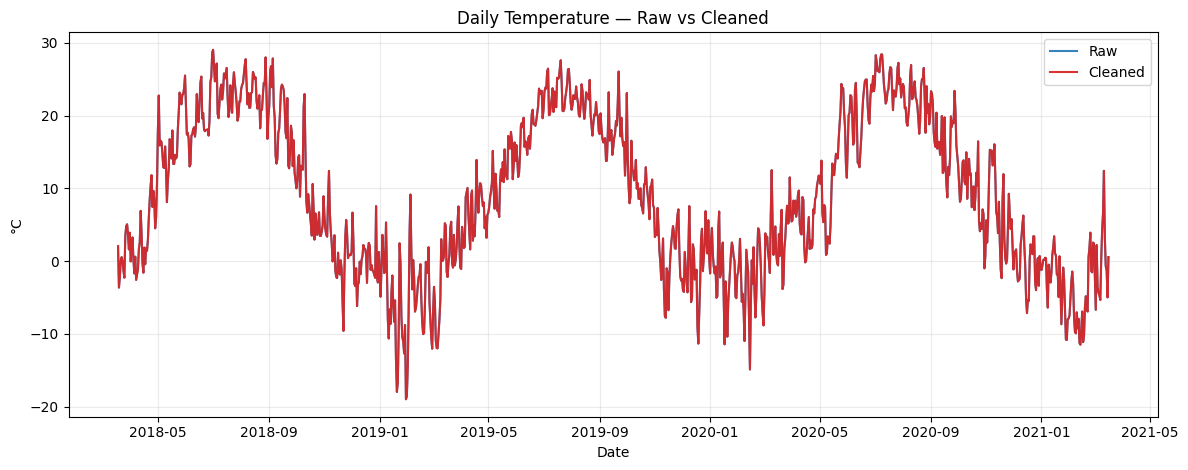

In [30]:
#  Plot — Raw vs Cleaned
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4.8))
plt.plot(df_raw['Date'],  df_raw['Temperature'],  label='Raw',     color='#1f77b4', alpha=0.90)  # blue
plt.plot(df_clean['Date'], df_clean['Temperature'], label='Cleaned', color='#d62728', alpha=0.95)  # red

imp = None
for c in ['was_imputed_ffill','was_imputed_clim','was_imputed_global']:
    imp = df_clean[c] if imp is None and c in df_clean.columns else (imp | df_clean[c]) if c in df_clean.columns else imp
if imp is not None and imp.any():
    plt.scatter(df_clean.loc[imp,'Date'], df_clean.loc[imp,'Temperature'],
                s=18, color='#e377c2', label='Imputed', zorder=3)  # magenta

plt.title('Daily Temperature — Raw vs Cleaned'); plt.xlabel('Date'); plt.ylabel('°C')
plt.legend(); plt.grid(alpha=0.25); plt.tight_layout(); plt.show()


## 4) Plot — Distribution

We compare the distribution (histograms) of raw vs cleaned temperatures.


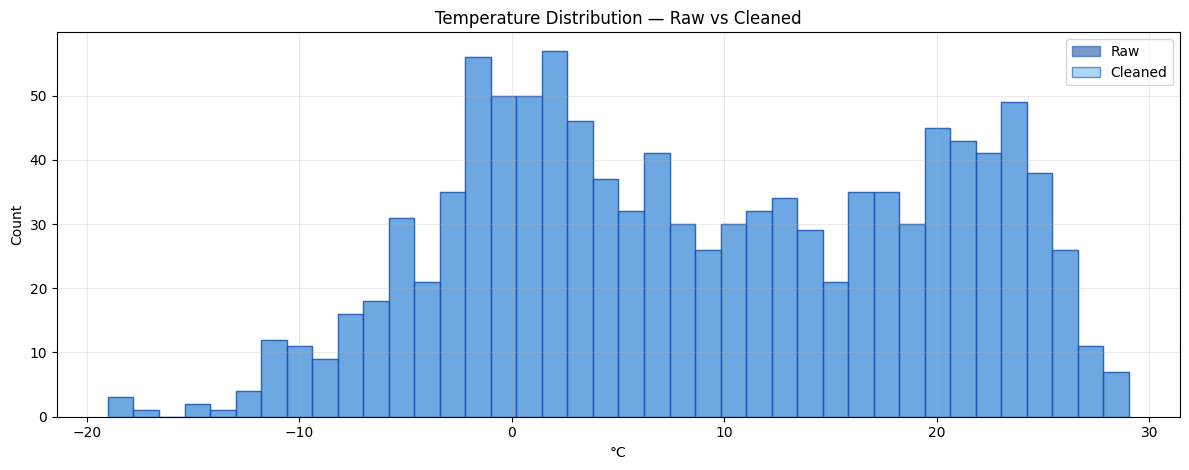

In [31]:
# Plot — Histogram overlay
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4.8))
plt.hist(df_raw['Temperature'].dropna(),  bins=40, alpha=0.55, label='Raw',
         color='#0d47a1', edgecolor='#0d47a1')         # deep blue
plt.hist(df_clean['Temperature'].dropna(), bins=40, alpha=0.55, label='Cleaned',
         color='#64b5f6', edgecolor='#0d47a1')         # light blue
plt.title('Temperature Distribution — Raw vs Cleaned')
plt.xlabel('°C'); plt.ylabel('Count'); plt.legend(); plt.grid(alpha=0.25)
plt.tight_layout(); plt.show()


## 5) Calendar Features (Cyclical)
We add sin/cos encodings of day-of-year and week-of-year, for cyclical encoding, ensuring days of different weeks/months/years are mathematically close to each other.


In [32]:
# Calendar features
import numpy as np, pandas as pd

df_feat = df_clean[['Date','Temperature']].copy()
df_feat['doy'] = df_feat['Date'].dt.dayofyear
df_feat['woy'] = df_feat['Date'].dt.isocalendar().week.astype(int)
df_feat['doy_sin'] = np.sin(2*np.pi*df_feat['doy']/365.25).astype('float32')
df_feat['doy_cos'] = np.cos(2*np.pi*df_feat['doy']/365.25).astype('float32')
df_feat['woy_sin'] = np.sin(2*np.pi*df_feat['woy']/52.0).astype('float32')
df_feat['woy_cos'] = np.cos(2*np.pi*df_feat['woy']/52.0).astype('float32')

df_feat.head(5)


Date  Temperature  doy  woy   doy_sin   doy_cos   woy_sin   woy_cos
0 2018-03-18         2.04   77   11  0.969843  0.243730  0.970942  0.239316
1 2018-03-19        -3.65   78   12  0.973892  0.227011  0.992709  0.120537
2 2018-03-20        -2.20   79   12  0.977653  0.210225  0.992709  0.120537
3 2018-03-21         0.10   80   12  0.981125  0.193376  0.992709  0.120537
4 2018-03-22         0.54   81   12  0.984306  0.176471  0.992709  0.120537

## 6) Chronological Split
We assign Train/Valid/Test partitions by index: 81% / 9% / 10% (no shuffling).


In [33]:
# 6) Split tags
N = len(df_feat); i_tr = int(0.81*N); i_va = int(0.90*N)
df_feat = df_feat.reset_index(drop=True)
df_feat['set'] = 'test'
df_feat.loc[:i_tr-1, 'set']     = 'train'
df_feat.loc[i_tr:i_va-1, 'set']  = 'valid'
df_feat['set'].value_counts()


set
train    886
test     110
valid     99
Name: count, dtype: int64

## 7) LSTM Test Results

In this experiment, we trained a univariate LSTM model using the past 90 days of temperature as input to predict the next day’s temperature.  
We split the dataset chronologically into **81% train, 9% validation, and 10% test**.  

**Evaluation on the test block (Dec 2020 – Mar 2021):**
- **MAE:** 2.37 °C  
- **RMSE:** 2.99 °C  
- **R²:** 0.58  
- Accuracy within ±2 °C: 50.9%  
- Accuracy within ±3 °C: 67.3%  
- Accuracy within ±5 °C: 91.8%

The plot compares the **actual daily mean temperature** (blue) with the **LSTM forecast** (orange).  
We see that the LSTM captures the overall trend and seasonal fluctuations, but still misses some sharp peaks and troughs.


set
train    886
test     110
valid     99
Name: count, dtype: int64
[Shapes] Xtr (796, 90, 1) | Xva (99, 90, 1) | Xte (110, 90, 1)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 90, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 96)             │        37,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,905 (171.50 KB)

 Trainable params: 43,905 (171.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - loss: 0.3364 - mae: 0.7128 - val_loss: 0.1176 - val_mae: 0.4133 - learning_rate: 0.0010
Epoch 2/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - loss: 0.0797 - mae: 0.3199 - val_loss: 0.0794 - val_mae: 0.3302 - learning_rate: 0.0010
Epoch 3/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.0679 - mae: 0.2903 - val_loss: 0.0831 - val_mae: 0.3402 - learning_rate: 0.0010
Epoch 4/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0609 - mae: 0.2673 - val_loss: 0.0791 - val_mae: 0.3318 - learning_rate: 0.0010
Epoch 5/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.0618 - mae: 0.2753 - val_loss: 0.0786 - val_mae: 0.3309 - learning_rate: 0.0010
Epoch 6/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.0596 - mae: 0.2728 - val_loss: 0.0765 - val_mae: 0.3261 - learning_rate: 0.0010
Epoch 7/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.0574 - mae: 0.2627 - val_loss: 0.0750 - val_mae: 0.3226 - learning_rate: 0.0010
Epoc

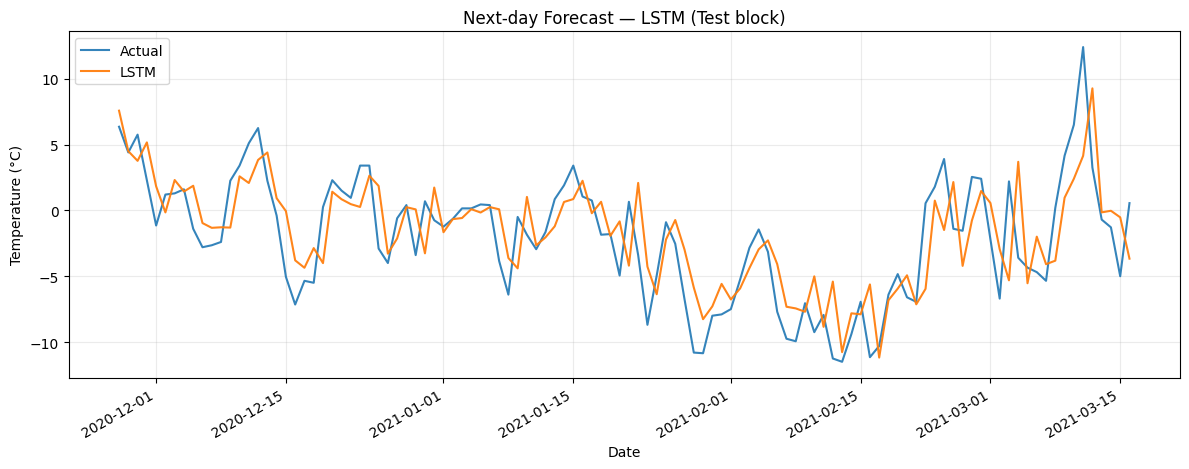

In [34]:


import io, os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from google.colab import files

# ----------  Chronological split ----------
N = len(df)
i_tr = int(0.81 * N)   # 81% train
i_va = int(0.90 * N)   # next 9% valid, last 10% test
df["set"] = "test"
df.loc[:i_tr-1, "set"] = "train"
df.loc[i_tr:i_va-1, "set"] = "valid"
print(df["set"].value_counts())

# ----------  Build sliding windows (univariate) ----------
# Using only Temperature; X_t = [T_{t-w},...,T_{t-1}] -> y_t = T_t
w = 90  # lookback window (you can change to 60/120 etc.)

temps = df["Temperature"].to_numpy(dtype="float32")
dates = df["Date"].to_numpy()

# indices of targets per split
idx_train = np.where(df["set"].values == "train")[0]
idx_valid = np.where(df["set"].values == "valid")[0]
idx_test  = np.where(df["set"].values == "test")[0]

# To create a sample (X,y) at target index t, we need t-w .. t-1 available.
def make_seqs(target_indices):
  X, y, dts = [], [], []
  for t in target_indices:
    if t - w < 0:
      continue
    # ensure the window doesn't cross the very beginning
    x_win = temps[t-w:t]
    if np.isnan(x_win).any():  # safety
      continue
    X.append(x_win[:, None])  # shape (w,1)
    y.append(temps[t])
    dts.append(dates[t])
  return np.array(X, dtype="float32"), np.array(y, dtype="float32"), np.array(dts)

Xtr, ytr, Dtr = make_seqs(idx_train)
Xva, yva, Dva = make_seqs(idx_valid)
Xte, yte, Dte = make_seqs(idx_test)

print("[Shapes] Xtr", Xtr.shape, "| Xva", Xva.shape, "| Xte", Xte.shape)

# ----------  Scale targets & inputs ----------
# We standardize Temperature for stability; remember to invert for plotting.
tr_mean = float(ytr.mean()); tr_std = float(ytr.std() + 1e-8)

def z(x):  return (x - tr_mean) / tr_std
def iz(x): return x * tr_std + tr_mean

ytr_s = z(ytr); yva_s = z(yva); yte_s = z(yte)

# For inputs, we can standardize with same stats (since it's the same variable)
Xtr_s = z(Xtr); Xva_s = z(Xva); Xte_s = z(Xte)

# ----------  LSTM model ----------
import tensorflow as tf
from tensorflow.keras import layers, Model

tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

inp = layers.Input(shape=(w,1), dtype="float32")
h   = layers.LSTM(96, return_sequences=False)(inp)
h   = layers.Dropout(0.25)(h)
h   = layers.Dense(64, activation="relu")(h)
out = layers.Dense(1)(h)

model = Model(inp, out)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss="huber", metrics=["mae"])
model.summary()

cb = [
  tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=30, mode="min", restore_best_weights=True),
  tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, min_lr=1e-5),
]

hist = model.fit(Xtr_s, ytr_s,
                 validation_data=(Xva_s, yva_s),
                 epochs=400, batch_size=64, verbose=1, callbacks=cb)

# ----------  Evaluate on Test & Plot (date-aligned) ----------
yhat_te_s = model.predict(Xte_s, batch_size=256).reshape(-1)
yhat_te   = iz(yhat_te_s)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
MAE  = float(mean_absolute_error(yte, yhat_te))
RMSE = float(np.sqrt(mean_squared_error(yte, yhat_te)))
R2   = float(r2_score(yte, yhat_te))
print(f"[Test] MAE={MAE:.3f} °C | RMSE={RMSE:.3f} °C | R^2={R2:.3f}")

# Tolerance-accuracy (±2/3/5 °C)
def acc_tol(y, yhat, k):
  return float(np.mean(np.abs(y - yhat) <= k))
for k in (2.0, 3.0, 5.0):
  print(f"Acc within ±{k:.0f}°C: {100*acc_tol(yte, yhat_te, k):.1f}%")

# Plot Actual vs LSTM on calendar dates
plt.figure(figsize=(12, 4.8))
plt.plot(Dte, yte,     label="Actual", alpha=0.9)   # default color
plt.plot(Dte, yhat_te, label="LSTM",   alpha=0.95)  # default color
plt.title("Next-day Forecast — LSTM (Test block)")
plt.xlabel("Date"); plt.ylabel("Temperature (°C)")
plt.legend(); plt.grid(alpha=0.25)
plt.gcf().autofmt_xdate()
plt.tight_layout(); plt.show()

## 8) Short-Term LSTM Forecast (Next 7 Days)

We trained a univariate LSTM model (90-day lookback) to forecast next-day temperature.  
Using the last 90 days of history up to **March 16, 2021**, we rolled the model forward recursively to obtain a **7-day forecast**.

**Forecast statistics (2021-03-17 → 2021-03-23):**
- Range: **0.59 °C → 2.24 °C**
- Mean: **1.00 °C**
- Median: **0.72 °C**
- Std: **0.60 °C**

**Interpretation:**
- The model captures short-term continuation of the recent warming trend.  
- Predictions remain within a narrow band, converging toward the training mean.  
- Short horizons (≤7 days) are more reliable, while longer horizons flatten out due to error accumulation and lack of seasonal features.

The plot compares the **last 60 actual days** (blue) with the **next 7-day forecast** (orange).


Saved forecast_next_7d.csv


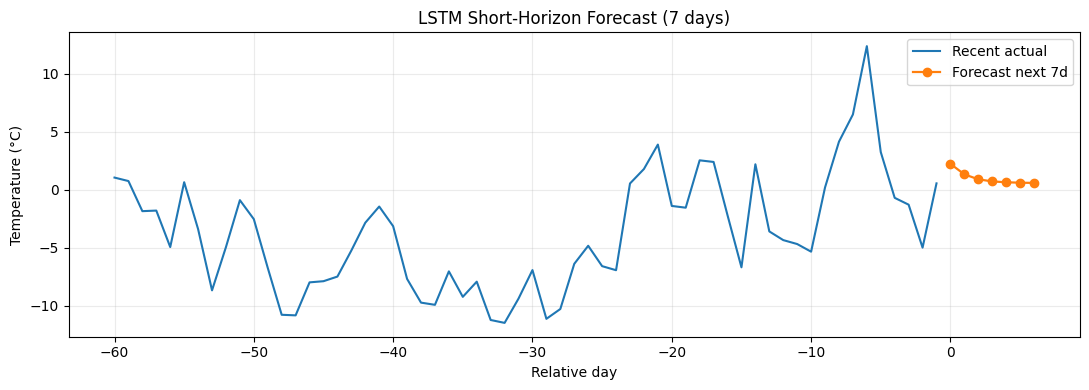

Range: 0.59 °C → 2.24 °C
Mean: 1.00 °C | Median: 0.72 °C
Std: 0.60 °C

7-day table:


Date      Pred
0 2021-03-17  2.235519
1 2021-03-18  1.327678
2 2021-03-19  0.901317
3 2021-03-20  0.719925
4 2021-03-21  0.644004
5 2021-03-22  0.609160
6 2021-03-23  0.588193


For slide:
2021-03-17: 2.2 °C
2021-03-18: 1.3 °C
2021-03-19: 0.9 °C
2021-03-20: 0.7 °C
2021-03-21: 0.6 °C
2021-03-22: 0.6 °C
2021-03-23: 0.6 °C


In [35]:
# ---- Short-horizon forecast (next H=7 days)----
import numpy as np, pandas as pd, matplotlib.pyplot as plt, datetime as dt

H = 7  # 7-day horizon

# sanity + helpers
assert all(k in globals() for k in ["df","model","w","tr_mean","tr_std"])
z  = lambda x: (x - tr_mean) / (tr_std + 1e-8)
iz = lambda x: x * (tr_std + 1e-8) + tr_mean

df = df.sort_values("Date").reset_index(drop=True)
temps = df["Temperature"].to_numpy(dtype="float32")
last_date = pd.to_datetime(df["Date"].iloc[-1]).date()
future_calendar = pd.date_range(last_date + dt.timedelta(days=1), periods=H, freq="D")

# last window (standardized)
win = z(temps[-w:].reshape(1, w, 1)).astype("float32")

# recursive rollout (short horizon)
preds = np.empty(H, dtype="float32")
for h in range(H):
    yhat_s = model.predict(win, verbose=0)[0,0]
    yhat   = iz(yhat_s)
    preds[h] = yhat
    yhat_s_std = (yhat - tr_mean) / (tr_std + 1e-8)
    win = np.concatenate([win[:,1:,:], yhat_s_std.reshape(1,1,1)], axis=1)

# save + quick overlay plot (last 60 actuals + H future)
df7 = pd.DataFrame({"Date": future_calendar, "Pred": preds})
df7.to_csv("forecast_next_7d.csv", index=False)
print("Saved forecast_next_7d.csv")

k_hist = min(60, len(temps))
plt.figure(figsize=(11,4))
plt.plot(np.arange(-k_hist, 0), temps[-k_hist:], label="Recent actual", linewidth=1.5)
plt.plot(np.arange(0, H), preds, label=f"Forecast next {H}d", marker="o", linewidth=1.6)
plt.title("LSTM Short-Horizon Forecast (7 days)"); plt.xlabel("Relative day"); plt.ylabel("Temperature (°C)")
plt.grid(alpha=0.25); plt.legend(); plt.tight_layout(); plt.show()

# ---- Summary stats + nicely formatted list for slide ----
print("Range:", f"{df7['Pred'].min():.2f} °C → {df7['Pred'].max():.2f} °C")
print("Mean:", f"{df7['Pred'].mean():.2f} °C", "| Median:", f"{df7['Pred'].median():.2f} °C")
print("Std:",  f"{df7['Pred'].std():.2f} °C")

print("\n7-day table:")
display(df7)

lst_for_slide = [f"{d.date()}: {v:.1f} °C" for d, v in zip(df7['Date'], df7['Pred'])]
print("\nFor slide:")
print("\n".join(lst_for_slide))


## 9) LSTM Helpers

Here, we build helper functions to:

- inversely standardize from z-score to the original target scale
- calculate accuracy within a tolerance band to find proportion of predictions under a specified standard error
- Compile and train a Keras model with early stopping and LR scheduling

In [ ]:
# Helpers for fair comparison
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# reproducibility
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# inverse standardization using your train stats
def iz(x):
    """
    Inverse standardization from z-score to original scale.

    Applies x * (tr_std + 1e-8) + tr_mean using training-set statistics.

    Args:
        x (np.ndarray or tf.Tensor): Standardized values.

    Returns:
        np.ndarray or tf.Tensor: Values mapped back to the original target scale.
    """
    return x * (tr_std + 1e-8) + tr_mean

def acc_tol(y, yhat, k):
    """
    Accuracy within a tolerance band.

    Computes the proportion of predictions whose absolute error is <= k.

    Args:
        y (np.ndarray): Ground-truth targets of shape (n_samples,).
        yhat (np.ndarray): Predicted targets of shape (n_samples,).
        k (float): Tolerance threshold (same unit as y).

    Returns:
        float: Fraction in [0.0, 1.0] of samples within ±k of the truth.
    """
    return float(np.mean(np.abs(y - yhat) <= k))

def evaluate_on_test(model, Xte_s, yte, name):
    """
    Evaluate a trained model on standardized test inputs and report metrics.

    Runs inference on standardized features, inverse-transforms predictions to the
    original scale, prints a summary line, and returns a metrics dict plus predictions.

    Args:
        model (tf.keras.Model): Trained Keras model.
        Xte_s (np.ndarray): Standardized test features of shape (n_samples, w, 1).
        yte (np.ndarray): Test targets in original scale of shape (n_samples,).
        name (str): Label used for printing and logging (e.g., model name).

    Returns:
        Tuple[dict, np.ndarray]:
            - metrics (dict): {"Model","MAE","RMSE","R2","Acc±2","Acc±3","Acc±5"}.
            - yhat_te (np.ndarray): Predictions on original scale, shape (n_samples,).
    """
    yhat_te_s = model.predict(Xte_s, batch_size=256, verbose=0).reshape(-1)
    yhat_te   = iz(yhat_te_s)
    mae  = float(mean_absolute_error(yte, yhat_te))
    rmse = float(np.sqrt(mean_squared_error(yte, yhat_te)))
    r2   = float(r2_score(yte, yhat_te))
    a2, a3, a5 = (100*acc_tol(yte,yhat_te,k) for k in (2.0,3.0,5.0))
    print(f"[{name}] MAE={mae:.3f} | RMSE={rmse:.3f} | R²={r2:.3f} | Acc±2={a2:.1f}% | Acc±3={a3:.1f}% | Acc±5={a5:.1f}%")
    return {"Model":name,"MAE":mae,"RMSE":rmse,"R2":r2,"Acc±2":a2,"Acc±3":a3,"Acc±5":a5}, yhat_te

# unified compile/fit
def compile_and_fit(model, Xtr_s, ytr_s, Xva_s, yva_s, epochs=400, batch_size=64):
    """
    Compile and train a Keras model with early stopping and LR scheduling.

    Uses Adam(1e-3) and Huber loss. Trains with EarlyStopping on val_mae and
    ReduceLROnPlateau on val_loss, restoring best weights.

    Args:
        model (tf.keras.Model): Uncompiled Keras model to train.
        Xtr_s (np.ndarray): Standardized train features, shape (n_train, w, 1).
        ytr_s (np.ndarray): Standardized train targets, shape (n_train,).
        Xva_s (np.ndarray): Standardized validation features, shape (n_val, w, 1).
        yva_s (np.ndarray): Standardized validation targets, shape (n_val,).
        epochs (int, optional): Maximum training epochs. Defaults to 400.
        batch_size (int, optional): Batch size. Defaults to 64.

    Returns:
        tf.keras.Model: The trained model (with best weights restored).
    """
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss="huber", metrics=["mae"])
    cb = [
        tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=30, mode="min", restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, min_lr=1e-5),
    ]
    _ = model.fit(Xtr_s, ytr_s, validation_data=(Xva_s, yva_s),
                  epochs=epochs, batch_size=batch_size, verbose=1, callbacks=cb)
    return model

# global holder for results/curves
NEW_RESULTS = []
PRED_BY_MODEL = {}


## 10) Train/Validation/Test Split

We split the data chronologically by 81/9/10% of total for train/validation/test splits.

We also create a sliding window model with a 90 day lookback.

In [37]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

# Chronological split (81/9/10)
N = len(df)
i_tr = int(0.81 * N)
i_va = int(0.90 * N)
df = df.sort_values("Date").reset_index(drop=True).copy()
df["set"] = "test"
df.loc[:i_tr-1, "set"] = "train"
df.loc[i_tr:i_va-1, "set"] = "valid"
print(df["set"].value_counts())

# Sliding windows (univariate next-day)
w = 90  # lookback
temps = df["Temperature"].to_numpy(dtype="float32")
dates = df["Date"].to_numpy()

idx_train = np.where(df["set"].values == "train")[0]
idx_valid = np.where(df["set"].values == "valid")[0]
idx_test  = np.where(df["set"].values == "test")[0]

def make_seqs(target_indices, window):
    X, y, dts = [], [], []
    for t in target_indices:
        if t - window < 0:
            continue
        x_win = temps[t-window:t]
        if np.isnan(x_win).any():
            continue
        X.append(x_win[:, None])  # (w,1)
        y.append(temps[t])
        dts.append(dates[t])
    return np.array(X, dtype="float32"), np.array(y, dtype="float32"), np.array(dts)

Xtr, ytr, Dtr = make_seqs(idx_train, w)
Xva, yva, Dva = make_seqs(idx_valid, w)
Xte, yte, Dte = make_seqs(idx_test,  w)
print("[Shapes] Xtr", Xtr.shape, "| Xva", Xva.shape, "| Xte", Xte.shape)

# Standardize by train targets
tr_mean = float(ytr.mean()); tr_std = float(ytr.std() + 1e-8)
def z(x):  return (x - tr_mean) / tr_std
def iz(x): return x * tr_std + tr_mean

ytr_s = z(ytr); yva_s = z(yva); yte_s = z(yte)
Xtr_s = z(Xtr); Xva_s = z(Xva); Xte_s = z(Xte)


set
train    886
test     110
valid     99
Name: count, dtype: int64
[Shapes] Xtr (796, 90, 1) | Xva (99, 90, 1) | Xte (110, 90, 1)


## 11) Model Training and Metrics

Functions to assist in model training and metrics display.

- retain model training history for future metrics use
- Huber loss and MAE plots for training and validation
- accuracy and tolerance calculation under k bound
- printing regression metrics after evaluationg on test data

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

tf.keras.backend.clear_session()
tf.random.set_seed(42); np.random.seed(42)

def compile_and_fit_hist(model, Xtr_s, ytr_s, Xva_s, yva_s, epochs=400, batch_size=64):
    """
    Compile and train a model while retaining the full training history.

    Uses Adam(1e-3) optimizer, Huber loss, and tracks MAE. Includes
    EarlyStopping (on val_mae) and ReduceLROnPlateau (on val_loss),
    restoring the best weights automatically.

    Args:
        model (tf.keras.Model): Keras model to train.
        Xtr_s (np.ndarray): Standardized training features (shape: [n_train, w, 1]).
        ytr_s (np.ndarray): Standardized training targets (shape: [n_train]).
        Xva_s (np.ndarray): Standardized validation features (shape: [n_val, w, 1]).
        yva_s (np.ndarray): Standardized validation targets (shape: [n_val]).
        epochs (int, optional): Maximum number of epochs. Defaults to 400.
        batch_size (int, optional): Batch size. Defaults to 64.

    Returns:
        Tuple[tf.keras.Model, tf.keras.callbacks.History]:
            - model: Trained model with best weights restored.
            - hist: History object with loss/metric curves.
    """
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss="huber", metrics=["mae"])
    cb = [
        tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=30, mode="min", restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, min_lr=1e-5),
    ]
    hist = model.fit(Xtr_s, ytr_s, validation_data=(Xva_s, yva_s),
                     epochs=epochs, batch_size=batch_size, verbose=1, callbacks=cb)
    return model, hist

def plot_history(hist, title):
    """
    Plot training and validation curves for Huber loss and MAE.

    Args:
        hist (tf.keras.callbacks.History): Keras training history object.
        title (str): Title prefix for the subplots.

    Returns:
        None: Displays matplotlib plots of training/validation loss and MAE.
    """
    h = hist.history
    fig, ax = plt.subplots(1, 2, figsize=(10, 3.8))
    ax[0].plot(h["loss"], label="train"); ax[0].plot(h["val_loss"], label="val")
    ax[0].set_title(f"{title} — Huber loss"); ax[0].set_xlabel("epoch"); ax[0].set_ylabel("loss"); ax[0].grid(alpha=0.3); ax[0].legend()
    ax[1].plot(h["mae"], label="train"); ax[1].plot(h["val_mae"], label="val")
    ax[1].set_title(f"{title} — MAE"); ax[1].set_xlabel("epoch"); ax[1].set_ylabel("MAE"); ax[1].grid(alpha=0.3); ax[1].legend()
    plt.tight_layout(); plt.show()

def acc_tol(y, yhat, k):
    """
    Accuracy within a tolerance band.

    Computes the proportion of predictions whose absolute error is <= k.

    Args:
        y (np.ndarray): Ground-truth targets of shape (n_samples,).
        yhat (np.ndarray): Predicted targets of shape (n_samples,).
        k (float): Tolerance threshold (same units as y).

    Returns:
        float: Fraction in [0.0, 1.0] of samples within ±k of the truth.
    """
    return float(np.mean(np.abs(y - yhat) <= k))

def evaluate_on_test(model, Xte_s, yte, name):
    """
    Evaluate a model on test data and print regression metrics.

    Runs inference on standardized inputs, inverse-transforms predictions,
    prints a summary line, and returns metrics and predictions.

    Args:
        model (tf.keras.Model): Trained model to evaluate.
        Xte_s (np.ndarray): Standardized test features, shape (n_test, w, 1).
        yte (np.ndarray): Ground-truth targets in original scale, shape (n_test,).
        name (str): Display name for the model.

    Returns:
        Tuple[dict, np.ndarray]:
            - metrics (dict): {"Model","MAE","RMSE","R2","Acc±2","Acc±3","Acc±5"}.
            - yhat_te (np.ndarray): Predictions on original scale.
    """
    yhat_te_s = model.predict(Xte_s, batch_size=256, verbose=0).reshape(-1)
    yhat_te   = iz(yhat_te_s)
    mae  = float(mean_absolute_error(yte, yhat_te))
    rmse = float(np.sqrt(mean_squared_error(yte, yhat_te)))
    r2   = float(r2_score(yte, yhat_te))
    a2, a3, a5 = (100*acc_tol(yte,yhat_te,k) for k in (2.0,3.0,5.0))
    print(f"[{name}] MAE={mae:.3f} | RMSE={rmse:.3f} | R²={r2:.3f} | Acc±2={a2:.1f}% | Acc±3={a3:.1f}% | Acc±5={a5:.1f}%")
    return {"Model":name,"MAE":mae,"RMSE":rmse,"R2":r2,"Acc±2":a2,"Acc±3":a3,"Acc±5":a5}, yhat_te

NEW_RESULTS = []
PRED_BY_MODEL = {}


## 12) Bidirectional LSTM

Definition of a bidirectional LSTM model with dropout and ReLU layers, as well as evaluation and plotting on test set. Evaluates for both Huber loss and MAE.

Epoch 1/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 195ms/step - loss: 0.3823 - mae: 0.7739 - val_loss: 0.0816 - val_mae: 0.3441 - learning_rate: 0.0010
Epoch 2/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0875 - mae: 0.3342 - val_loss: 0.0982 - val_mae: 0.3502 - learning_rate: 0.0010
Epoch 3/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0656 - mae: 0.2832 - val_loss: 0.0755 - val_mae: 0.3265 - learning_rate: 0.0010
Epoch 4/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0653 - mae: 0.2830 - val_loss: 0.0741 - val_mae: 0.3215 - learning_rate: 0.0010
Epoch 5/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0609 - mae: 0.2750 - val_loss: 0.0747 - val_mae: 0.3215 - learning_rate: 0.0010
Epoch 6/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0588 - mae: 0.2703 - val_loss: 0.0738 - val_mae: 0.3194 - learning_rate: 0.0010
Epoch 7/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0591 - mae: 0.2731 - val_loss: 0.0733 - val_mae: 0.3202 - learning_rate: 0.0010
Epoch

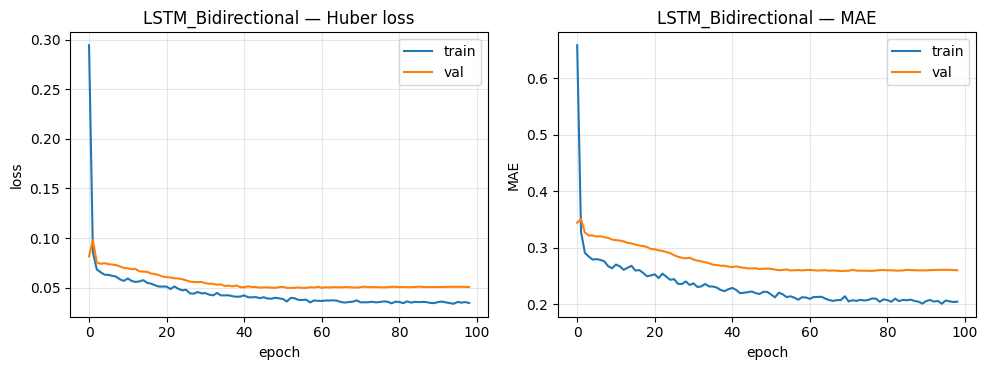

[LSTM_Bidirectional] MAE=2.306 | RMSE=2.935 | R²=0.599 | Acc±2=53.6% | Acc±3=70.9% | Acc±5=92.7%


In [39]:
inp = layers.Input(shape=(w,1))
h   = layers.Bidirectional(layers.LSTM(64, return_sequences=False))(inp)
h   = layers.Dropout(0.25)(h)
h   = layers.Dense(64, activation="relu")(h)
out = layers.Dense(1)(h)
model_bi = Model(inp, out, name="LSTM_Bidirectional")

model_bi, hist_bi = compile_and_fit_hist(model_bi, Xtr_s, ytr_s, Xva_s, yva_s)
plot_history(hist_bi, model_bi.name)
m, yhat = evaluate_on_test(model_bi, Xte_s, yte, model_bi.name)
NEW_RESULTS.append(m); PRED_BY_MODEL[model_bi.name] = yhat


## 13) Additive Attention LSTM

Definition of an additive attention LSTM model with dropout and ReLU layers, as well as evaluation and plotting on test set. Evaluates for both Huber loss and MAE.

Epoch 1/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 173ms/step - loss: 0.3783 - mae: 0.7757 - val_loss: 0.2462 - val_mae: 0.5879 - learning_rate: 0.0010
Epoch 2/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.2942 - mae: 0.6639 - val_loss: 0.2061 - val_mae: 0.5321 - learning_rate: 0.0010
Epoch 3/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - loss: 0.2661 - mae: 0.6258 - val_loss: 0.2042 - val_mae: 0.5310 - learning_rate: 0.0010
Epoch 4/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 0.2001 - mae: 0.5250 - val_loss: 0.1484 - val_mae: 0.4565 - learning_rate: 0.0010
Epoch 5/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.1209 - mae: 0.3928 - val_loss: 0.1436 - val_mae: 0.4530 - learning_rate: 0.0010
Epoch 6/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - loss: 0.1087 - mae: 0.3713 - val_loss: 0.1204 - val_mae: 0.4059 - learning_rate: 0.0010
Epoch 7/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - loss: 0.1024 - mae: 0.3588 - val_loss: 0.1122 - val_mae: 0.3832 - learning_rate: 0.0010

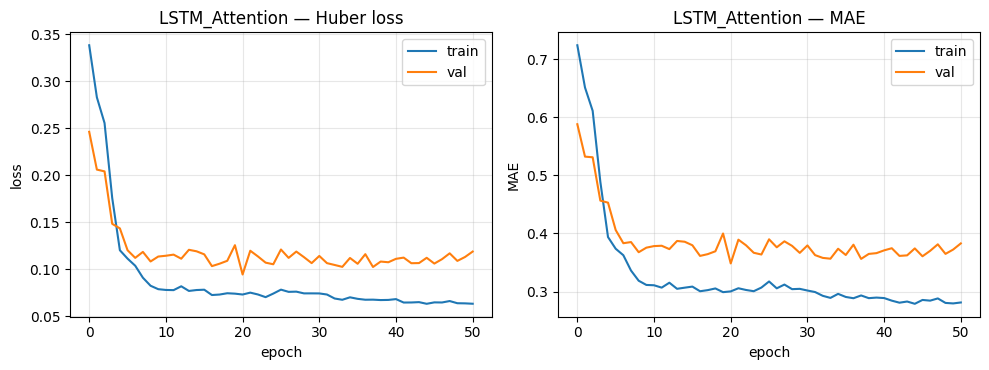

[LSTM_Attention] MAE=5.893 | RMSE=7.030 | R²=-1.303 | Acc±2=18.2% | Acc±3=24.5% | Acc±5=47.3%


In [ ]:
class AdditiveAttention(layers.Layer):
    """
    Simple additive attention mechanism for sequence models.

    Projects hidden states into a learned representation, computes attention
    weights via a tanh + dense scoring function, normalizes with softmax,
    and returns a weighted sum (context vector).

    Attributes:
        W (tf.keras.layers.Dense): Dense projection for hidden states.
        V (tf.keras.layers.Dense): Dense projection to scalar attention scores.
    """
    def __init__(self, units=64):
        super().__init__(); self.W = layers.Dense(units, use_bias=False); self.V = layers.Dense(1, use_bias=False)
    def call(self, H):                             # H: (B,T,F)
        """
        Compute the context vector given a sequence of hidden states.

        Args:
            H (tf.Tensor): Hidden states of shape (batch, time, features).

        Returns:
            tf.Tensor: Context vector of shape (batch, features),
            representing the weighted sum of hidden states.
        """
        
        score = self.V(tf.nn.tanh(self.W(H)))      # (B,T,1)
        alpha = tf.nn.softmax(score, axis=1)       # (B,T,1)
        ctx   = tf.reduce_sum(alpha * H, axis=1)   # (B,F)
        return ctx

inp = layers.Input(shape=(w,1))
H   = layers.LSTM(96, return_sequences=True)(inp)
ctx = AdditiveAttention(64)(H)
h   = layers.Dropout(0.25)(ctx)
h   = layers.Dense(64, activation="relu")(h)
out = layers.Dense(1)(h)
model_attn = Model(inp, out, name="LSTM_Attention")

model_attn, hist_attn = compile_and_fit_hist(model_attn, Xtr_s, ytr_s, Xva_s, yva_s)
plot_history(hist_attn, model_attn.name)
m, yhat = evaluate_on_test(model_attn, Xte_s, yte, model_attn.name)
NEW_RESULTS.append(m); PRED_BY_MODEL[model_attn.name] = yhat


## 14) Multi-Head Attention LSTM

Definition of a multi-head attention LSTM model with dropout and ReLU layers, as well as evaluation and plotting on test set. The model is also normalized with additional dropout. Evaluates for both Huber loss and MAE.

Epoch 1/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 263ms/step - loss: 0.3766 - mae: 0.7394 - val_loss: 0.5346 - val_mae: 0.9644 - learning_rate: 0.0010
Epoch 2/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 200ms/step - loss: 0.2171 - mae: 0.5327 - val_loss: 0.2045 - val_mae: 0.5383 - learning_rate: 0.0010
Epoch 3/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 198ms/step - loss: 0.1476 - mae: 0.4305 - val_loss: 0.1631 - val_mae: 0.4941 - learning_rate: 0.0010
Epoch 4/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 225ms/step - loss: 0.1362 - mae: 0.4204 - val_loss: 0.1032 - val_mae: 0.3534 - learning_rate: 0.0010
Epoch 5/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 215ms/step - loss: 0.1274 - mae: 0.4054 - val_loss: 0.0986 - val_mae: 0.3517 - learning_rate: 0.0010
Epoch 6/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 293ms/step - loss: 0.1029 - mae: 0.3620 - val_loss: 0.0939 - val_mae: 0.3506 - learning_rate: 0.0010
Epoch 7/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 439ms/step - loss: 0.0974 - mae: 0.3471 - val_loss: 0.1145 - val_mae: 0.3641 - learning_rate: 0.0010

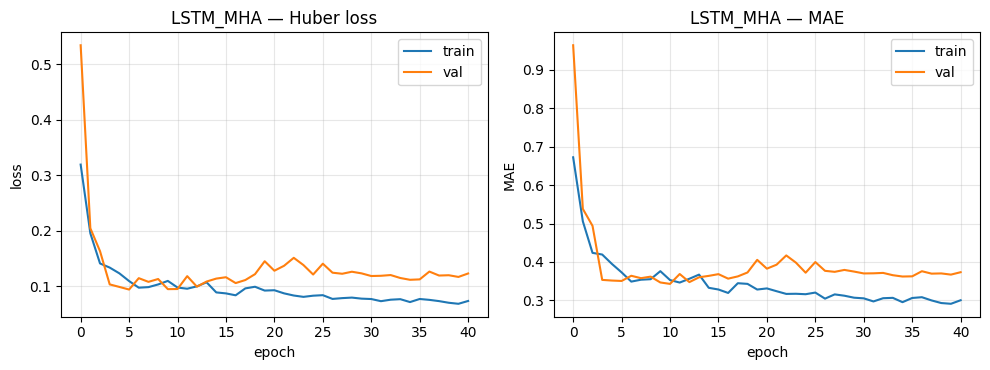

[LSTM_MHA] MAE=4.483 | RMSE=5.438 | R²=-0.378 | Acc±2=27.3% | Acc±3=41.8% | Acc±5=60.0%


In [42]:
inp = layers.Input(shape=(w,1))
H   = layers.LSTM(96, return_sequences=True)(inp)
A   = layers.MultiHeadAttention(num_heads=4, key_dim=24, dropout=0.10)(H, H)
H2  = layers.Add()([H, A])
H2  = layers.LayerNormalization(epsilon=1e-5)(H2)
g   = layers.GlobalAveragePooling1D()(H2)
g   = layers.Dropout(0.25)(g)
g   = layers.Dense(64, activation="relu")(g)
out = layers.Dense(1)(g)
model_mha = Model(inp, out, name="LSTM_MHA")

model_mha, hist_mha = compile_and_fit_hist(model_mha, Xtr_s, ytr_s, Xva_s, yva_s)
plot_history(hist_mha, model_mha.name)
m, yhat = evaluate_on_test(model_mha, Xte_s, yte, model_mha.name)
NEW_RESULTS.append(m); PRED_BY_MODEL[model_mha.name] = yhat


## 15) Residual LSTM

Definition of a residual LSTM model with global average pooling, then dropout and ReLU layers, as well as evaluation and plotting on test set. Evaluates for both Huber loss and MAE.

Epoch 1/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 206ms/step - loss: 0.2756 - mae: 0.6260 - val_loss: 0.1140 - val_mae: 0.4098 - learning_rate: 0.0010
Epoch 2/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - loss: 0.1031 - mae: 0.3546 - val_loss: 0.1116 - val_mae: 0.4013 - learning_rate: 0.0010
Epoch 3/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - loss: 0.0813 - mae: 0.3192 - val_loss: 0.0999 - val_mae: 0.3724 - learning_rate: 0.0010
Epoch 4/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 219ms/step - loss: 0.0722 - mae: 0.3010 - val_loss: 0.0923 - val_mae: 0.3503 - learning_rate: 0.0010
Epoch 5/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 207ms/step - loss: 0.0712 - mae: 0.2993 - val_loss: 0.0903 - val_mae: 0.3476 - learning_rate: 0.0010
Epoch 6/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step - loss: 0.0692 - mae: 0.2922 - val_loss: 0.0914 - val_mae: 0.3526 - learning_rate: 0.0010
Epoch 7/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - loss: 0.0652 - mae: 0.2821 - val_loss: 0.0878 - val_mae: 0.3443 - learning_rate: 0.0010

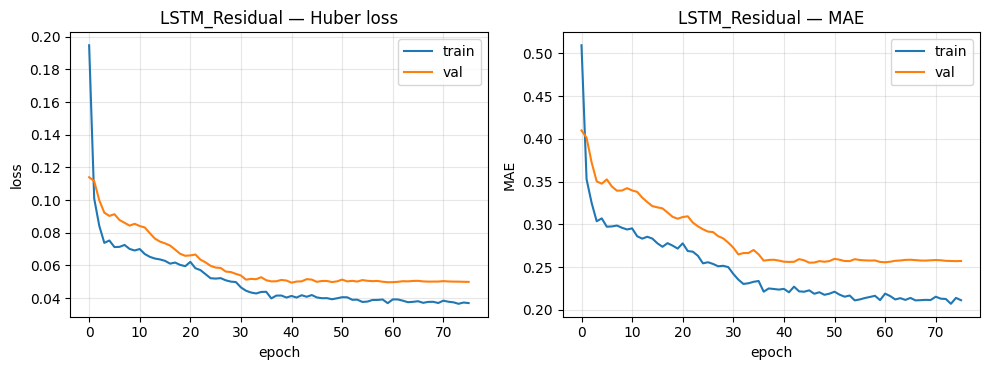

[LSTM_Residual] MAE=2.400 | RMSE=3.050 | R²=0.566 | Acc±2=49.1% | Acc±3=63.6% | Acc±5=90.9%


In [43]:
inp = layers.Input(shape=(w,1))
H   = layers.LSTM(96, return_sequences=True)(inp)
h   = layers.LSTM(64, return_sequences=False)(H)
s   = layers.GlobalAveragePooling1D()(inp)     # shortcut from raw input
h   = layers.Concatenate()([h, s])
h   = layers.Dropout(0.25)(h)
h   = layers.Dense(64, activation="relu")(h)
out = layers.Dense(1)(h)
model_res = Model(inp, out, name="LSTM_Residual")

model_res, hist_res = compile_and_fit_hist(model_res, Xtr_s, ytr_s, Xva_s, yva_s)
plot_history(hist_res, model_res.name)
m, yhat = evaluate_on_test(model_res, Xte_s, yte, model_res.name)
NEW_RESULTS.append(m); PRED_BY_MODEL[model_res.name] = yhat


## 16) Teat Metrics Results

Metrics and a chart showcasing results of different LSTM models with different layer types, including:

- 96 or 48 units
- default LSTM models without specification
- bidirecitonal models
- stacked models
- residual models
- different attention mechanissms

Bidirectional modelss performed best, followed by residual models and stacked models. Some amount of complexity helped, but the ability to look forwards and back remained the best option for LSTM models on time series data.

Model       MAE      RMSE        R2      Acc±2      Acc±3  \
0            LSTM_Bi_u96  2.215713  2.811162  0.631679  51.818182  66.363636   
1            LSTM_Bi_u48  2.259676  2.862693  0.618051  50.000000  70.909091   
2     LSTM_Bidirectional  2.305944  2.934531  0.598641  53.636364  70.909091   
3   LSTM_Residual_u48-32  2.389556  2.982983  0.585278  50.000000  68.181818   
4   LSTM_Residual_u48-64  2.388127  2.991585  0.582883  50.000000  66.363636   
5           LSTM_Stacked  2.390579  3.007451  0.578447  50.909091  65.454545   
6        LSTM_Single_u96  2.372294  3.007516  0.578429  51.818182  65.454545   
7   LSTM_Residual_u96-32  2.385027  3.020152  0.574879  49.090909  63.636364   
8    LSTM_Stacked_u48-64  2.386549  3.032458  0.571407  48.181818  65.454545   
9        LSTM_Single_u96  2.386064  3.036530  0.570255  50.000000  67.272727   
10  LSTM_Residual_u96-64  2.390195  3.045336  0.567759  48.181818  62.727273   
11         LSTM_Residual  2.399740  3.049992  0.566437  49.090909  63.636364   
12   LSTM_Stacked_u96-64  2.390178  3.062250  0.562945  47.272727  62.727273   
13       LSTM_Single_u48  2.412657  3.102138  0.551485  49.090909  61.818182   
14       LSTM_Single_u48  2.445014  3.121884  0.545756  49.090909  60.000000   
15   LSTM_Stacked_u48-32  2.464059  3.131793  0.542868  46.363636  60.909091   
16       LSTM_Single_u48  2.525794  3.226501  0.514802  47.272727  59.090909   
17   LSTM_Stacked_u96-32  2.670395  3.333538  0.482076  44.545455  60.909091   
18         LSTM_Attn_u48  3.362597  4.271744  0.149517  40.909091  52.727273   
19         LSTM_Attn_u96  4.079899  5.006441 -0.168190  29.090909  43.636364   
20   LSTM_MHA_u48-h4-k24  4.124693  5.169761 -0.245650  29.090909  40.000000   
21   LSTM_MHA_u48-h4-k16  4.151639  5.175600 -0.248466  31.818182  41.818182   
22              LSTM_MHA  4.483351  5.438022 -0.378279  27.272727  41.818182   
23   LSTM_MHA_u96-h4-k24  5.533020  6.487314 -0.961485  20.909091  30.909091   
24   LSTM_MHA_u96-h4-k16  5.914186  6.982999 -1.272685  17.272727  26.363636   
25        LSTM_Attention  5.892623  7.029521 -1.303067  18.181818  24.545455   

        Acc±5  
0   91.818182  
1   93.636364  
2   92.727273  
3   90.000000  
4   90.000000  
5   90.909091  
6   90.000000  
7   90.000000  
8   90.909091  
9   90.000000  
10  90.000000  
11  90.909091  
12  90.000000  
13  89.090909  
14  88.181818  
15  90.000000  
16  90.000000  
17  87.272727  
18  74.545455  
19  65.454545  
20  68.181818  
21  64.545455  
22  60.000000  
23  42.727273  
24  42.727273  
25  47.272727

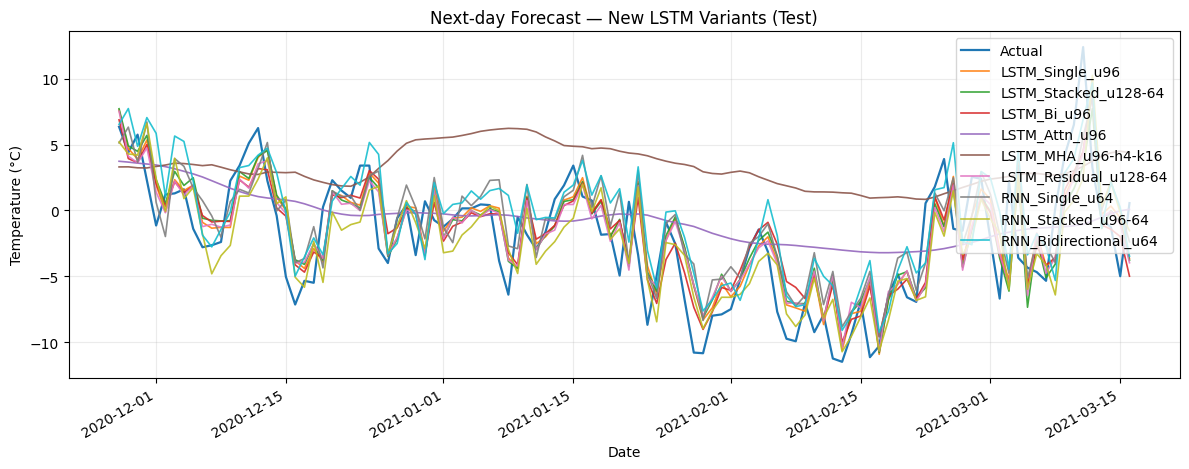

In [86]:
cmp_new = pd.DataFrame(NEW_RESULTS).sort_values(["RMSE","MAE"]).reset_index(drop=True)
display(cmp_new)

plt.figure(figsize=(12,4.8))
plt.plot(Dte, yte, label="Actual", linewidth=1.6)
for name, yhat in PRED_BY_MODEL.items():
    plt.plot(Dte, yhat, label=name, alpha=0.9, linewidth=1.2)
plt.title("Next-day Forecast — New LSTM Variants (Test)")
plt.xlabel("Date"); plt.ylabel("Temperature (°C)")
plt.legend(); plt.grid(alpha=0.25); plt.gcf().autofmt_xdate(); plt.tight_layout(); plt.show()


## 17) More Helper Functions + Model Building

Input sanitizing, helpers for tolerance, standardization, and attention layers. Also a parent function to build alll models used for further testing, all using input sanitization.

In [ ]:
# ==== LSTM family sweep  ====
import re, itertools, tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np, pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Assumes these already exist from your preprocessing:
# w, Xtr_s, ytr_s, Xva_s, yva_s, Xte_s, yte, tr_mean, tr_std

tf.keras.backend.clear_session()
tf.random.set_seed(42); np.random.seed(42)

# ---------- utils ----------
def _safe_name(s: str) -> str:
    """
    Sanitize a model name for Keras/TensorFlow.

    Replaces illegal characters with underscores and ensures the name starts
    with an alphanumeric or a dot, which avoids issues when compiling/saving models.

    Args:
        s (str): Proposed model name.

    Returns:
        str: A sanitized, Keras-safe model name.
    """
    s = re.sub(r'[^A-Za-z0-9._\/>\-]+', '_', s)   # replace illegal chars with '_'
    if not re.match(r'^[A-Za-z0-9.]', s):         # must start with [A-Za-z0-9.]
        s = 'M' + s
    return s

def iz(x):
    """
    Inverse standardization from z-score back to original scale.

    Applies x * std + mean using training statistics (tr_std, tr_mean).

    Args:
        x (np.ndarray or tf.Tensor): Standardized values.

    Returns:
        np.ndarray or tf.Tensor: Values mapped back to the original scale.
    """
    return x * (tr_std + 1e-8) + tr_mean

def acc_tol(y, yhat, k):
    """
    Accuracy within a tolerance band.

    Computes the percentage of predictions whose absolute error is <= k.

    Args:
        y (np.ndarray): Ground-truth targets (shape: [n_samples]).
        yhat (np.ndarray): Predictions (shape: [n_samples]).
        k (float): Tolerance threshold (same unit as y).

    Returns:
        float: Proportion of samples within ±k, in [0.0, 1.0].
    """
    return float(np.mean(np.abs(y - yhat) <= k))

def evaluate_on_test(model, Xte_s, yte):
    """
    Evaluate a trained model on standardized test inputs and return metrics.

    Runs inference on standardized inputs, inverse-transforms predictions to the
    original target scale, and computes common regression metrics.

    Args:
        model (tf.keras.Model): Trained Keras model.
        Xte_s (np.ndarray): Standardized test features (shape: [n, w, 1]).
        yte (np.ndarray): Test targets in original scale (shape: [n]).

    Returns:
        Tuple[dict, np.ndarray]:
            - metrics (dict): {"Model", "MAE", "RMSE", "R2", "Acc±2", "Acc±3", "Acc±5"}.
            - yhat (np.ndarray): Predictions on original scale (shape: [n]).
    """

    
    yhat_s = model.predict(Xte_s, batch_size=256, verbose=0).reshape(-1)
    yhat   = iz(yhat_s)
    mae  = float(mean_absolute_error(yte, yhat))
    rmse = float(np.sqrt(mean_squared_error(yte, yhat)))
    r2   = float(r2_score(yte, yhat))
    a2, a3, a5 = (100*acc_tol(yte,yhat,k) for k in (2.0,3.0,5.0))
    return {"Model":model.name,"MAE":mae,"RMSE":rmse,"R2":r2,"Acc±2":a2,"Acc±3":a3,"Acc±5":a5}, yhat

def compile_and_fit_hist_SAFE(model, Xtr_s, ytr_s, Xva_s, yva_s, epochs=160, batch_size=64):
    model._name = _safe_name(model.name)                   # sanitize before compile
    assert '(' not in model.name and ')' not in model.name
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss="huber", metrics=["mae"])
    cb = [
        tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=30, mode="min", restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, min_lr=1e-5),
    ]
    hist = model.fit(Xtr_s, ytr_s, validation_data=(Xva_s, yva_s),
                     epochs=epochs, batch_size=batch_size, verbose=1, callbacks=cb)
    return model, hist

# ---------- attention layer ----------
class AdditiveAttention(layers.Layer):
    def __init__(self, units=64):
        class AdditiveAttention(layers.Layer):
            """
    Simple additive attention layer over a sequence of hidden states.

    Applies a learned dense projection and tanh nonlinearity to compute
    attention scores, then returns the weighted sum (context vector).
    """

    
    def __init__(self, units=64):
        """
        Initialize the attention projections.

        Args:
            units (int, optional): Hidden size of the score projection. Defaults to 64.
        """
        super().__init__()
        self.W = layers.Dense(units, use_bias=False)
        self.V = layers.Dense(1,    use_bias=False)

    def call(self, H):
        """
        Compute context vector from a sequence of hidden states.

        Args:
            H (tf.Tensor): Hidden states (shape: [batch, time, dim]).

        Returns:
            tf.Tensor: Context vector (shape: [batch, dim]).
        """
        score = self.V(tf.nn.tanh(self.W(H)))
        alpha = tf.nn.softmax(score, axis=1)
        return tf.reduce_sum(alpha * H, axis=1)

        super().__init__()
        self.W = layers.Dense(units, use_bias=False)
        self.V = layers.Dense(1,    use_bias=False)
    def call(self, H):
        score = self.V(tf.nn.tanh(self.W(H)))
        alpha = tf.nn.softmax(score, axis=1)
        return tf.reduce_sum(alpha * H, axis=1)

# ---------- safe builders ----------
def build_model_safe(arch, w,
                     units1=64, units2=64,
                     dropout1=0.20, dropout2=0.25,
                     num_heads=4, key_dim=16,
                     name_suffix=""):
    """
    Build and return a compiled LSTM-based model with optional variants.

    Supported architectures:
      - "single": Single LSTM -> Dropout -> Dense -> output.
      - "stacked": Two LSTMs (return_sequences on first) -> Dropouts -> Dense -> output.
      - "bidir": Bidirectional LSTM -> Dropout -> Dense -> output.
      - "attn": LSTM (seq) -> AdditiveAttention -> Dropout -> Dense -> output.
      - "mha": LSTM (seq) -> MultiHeadAttention (+residual + LN) -> GAP -> Dense -> output.
      - "res":  LSTM (seq) -> LSTM + pooled skip concat -> Dropout -> Dense -> output.

    Args:
        arch (str): One of {"single","stacked","bidir","attn","mha","res"}.
        w (int): Input window length (timesteps).
        units1 (int, optional): Units in the first LSTM layer. Defaults to 64.
        units2 (int, optional): Units in the second LSTM layer (if applicable). Defaults to 64.
        dropout1 (float, optional): Dropout rate after the first LSTM (if used). Defaults to 0.20.
        dropout2 (float, optional): Dropout rate before output head. Defaults to 0.25.
        num_heads (int, optional): Number of heads for MultiHeadAttention (mha). Defaults to 4.
        key_dim (int, optional): Key dimension for MultiHeadAttention (mha). Defaults to 16.
        name_suffix (str, optional): Optional suffix appended to the model name.

    Returns:
        tf.keras.Model: Uncompiled Keras model with the chosen architecture and safe name.

    Raises:
        ValueError: If an unknown architecture is requested.
    """
    inp = layers.Input(shape=(w,1))
    if arch == "single":
        x = layers.LSTM(units1)(inp)
        x = layers.Dropout(dropout2)(x)
        x = layers.Dense(64, activation="relu")(x)
        out = layers.Dense(1)(x)
        raw = f"LSTM_Single_u{units1}{name_suffix}"

    elif arch == "stacked":
        x = layers.LSTM(units1, return_sequences=True)(inp)
        x = layers.Dropout(dropout1)(x)
        x = layers.LSTM(units2)(x)
        x = layers.Dropout(dropout2)(x)
        x = layers.Dense(64, activation="relu")(x)
        out = layers.Dense(1)(x)
        raw = f"LSTM_Stacked_u{units1}-{units2}{name_suffix}"

    elif arch == "bidir":
        x = layers.Bidirectional(layers.LSTM(units1))(inp)
        x = layers.Dropout(dropout2)(x)
        x = layers.Dense(64, activation="relu")(x)
        out = layers.Dense(1)(x)
        raw = f"LSTM_Bi_u{units1}{name_suffix}"

    elif arch == "attn":
        H = layers.LSTM(units1, return_sequences=True)(inp)
        ctx = AdditiveAttention(64)(H)
        x = layers.Dropout(dropout2)(ctx)
        x = layers.Dense(64, activation="relu")(x)
        out = layers.Dense(1)(x)
        raw = f"LSTM_Attn_u{units1}{name_suffix}"

    elif arch == "mha":
        H = layers.LSTM(units1, return_sequences=True)(inp)
        A = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim, dropout=0.10)(H, H)
        H2 = layers.Add()([H, A])
        H2 = layers.LayerNormalization(epsilon=1e-5)(H2)
        x  = layers.GlobalAveragePooling1D()(H2)
        x  = layers.Dropout(dropout2)(x)
        x  = layers.Dense(64, activation="relu")(x)
        out = layers.Dense(1)(x)
        raw = f"LSTM_MHA_u{units1}-h{num_heads}-k{key_dim}{name_suffix}"

    elif arch == "res":
        H = layers.LSTM(units1, return_sequences=True)(inp)
        x = layers.LSTM(units2)(H)
        s = layers.GlobalAveragePooling1D()(inp)
        x = layers.Concatenate()([x, s])
        x = layers.Dropout(dropout2)(x)
        x = layers.Dense(64, activation="relu")(x)
        out = layers.Dense(1)(x)
        raw = f"LSTM_Residual_u{units1}-{units2}{name_suffix}"

    else:
        raise ValueError("Unknown arch")

    return Model(inp, out, name=_safe_name(raw))

# ---------- sweep space ----------
ARCHES   = ["single", "stacked", "bidir", "attn", "mha", "res"]
UNITS1   = [48, 96]
UNITS2   = [32, 64]
DROPS    = [(0.15, 0.25)]
MHA_HEAD = [4]
MHA_KDIM = [16, 24]
EPOCHS_SWEEP = 160
BATCH_SWEEP  = 64

# ---------- TRAIN ONLY: run sweep (no plotting here) ----------
NEW_RESULTS     = [] if 'NEW_RESULTS'     not in globals() else NEW_RESULTS
PRED_BY_MODEL   = {} if 'PRED_BY_MODEL'   not in globals() else PRED_BY_MODEL
HIST_BY_MODEL   = {} if 'HIST_BY_MODEL'   not in globals() else HIST_BY_MODEL
SWEEP_RESULTS   = []

for arch in ARCHES:
    if arch == "single":
        for u1, (d1, d2) in itertools.product(UNITS1, DROPS):
            m = build_model_safe(arch, w, units1=u1, dropout1=d1, dropout2=d2)
            print("Training:", m.name)
            m, h = compile_and_fit_hist_SAFE(m, Xtr_s, ytr_s, Xva_s, yva_s, epochs=EPOCHS_SWEEP, batch_size=BATCH_SWEEP)
            metr, yhat = evaluate_on_test(m, Xte_s, yte)
            SWEEP_RESULTS.append(metr); NEW_RESULTS.append(metr)
            PRED_BY_MODEL[m.name] = yhat
            HIST_BY_MODEL[m.name] = h.history  # store curves (no plot)

    elif arch == "stacked":
        for u1, u2, (d1, d2) in itertools.product(UNITS1, UNITS2, DROPS):
            m = build_model_safe(arch, w, units1=u1, units2=u2, dropout1=d1, dropout2=d2)
            print("Training:", m.name)
            m, h = compile_and_fit_hist_SAFE(m, Xtr_s, ytr_s, Xva_s, yva_s, epochs=EPOCHS_SWEEP, batch_size=BATCH_SWEEP)
            metr, yhat = evaluate_on_test(m, Xte_s, yte)
            SWEEP_RESULTS.append(metr); NEW_RESULTS.append(metr)
            PRED_BY_MODEL[m.name] = yhat
            HIST_BY_MODEL[m.name] = h.history

    elif arch == "bidir":
        for u1 in UNITS1:
            m = build_model_safe(arch, w, units1=u1)
            print("Training:", m.name)
            m, h = compile_and_fit_hist_SAFE(m, Xtr_s, ytr_s, Xva_s, yva_s, epochs=EPOCHS_SWEEP, batch_size=BATCH_SWEEP)
            metr, yhat = evaluate_on_test(m, Xte_s, yte)
            SWEEP_RESULTS.append(metr); NEW_RESULTS.append(metr)
            PRED_BY_MODEL[m.name] = yhat
            HIST_BY_MODEL[m.name] = h.history

    elif arch == "attn":
        for u1 in UNITS1:
            m = build_model_safe(arch, w, units1=u1, dropout2=0.25)
            print("Training:", m.name)
            m, h = compile_and_fit_hist_SAFE(m, Xtr_s, ytr_s, Xva_s, yva_s, epochs=EPOCHS_SWEEP, batch_size=BATCH_SWEEP)
            metr, yhat = evaluate_on_test(m, Xte_s, yte)
            SWEEP_RESULTS.append(metr); NEW_RESULTS.append(metr)
            PRED_BY_MODEL[m.name] = yhat
            HIST_BY_MODEL[m.name] = h.history

    elif arch == "mha":
        for u1, nh, kd in itertools.product(UNITS1, MHA_HEAD, MHA_KDIM):
            m = build_model_safe(arch, w, units1=u1, num_heads=nh, key_dim=kd, dropout2=0.25)
            print("Training:", m.name)
            m, h = compile_and_fit_hist_SAFE(m, Xtr_s, ytr_s, Xva_s, yva_s, epochs=EPOCHS_SWEEP, batch_size=BATCH_SWEEP)
            metr, yhat = evaluate_on_test(m, Xte_s, yte)
            SWEEP_RESULTS.append(metr); NEW_RESULTS.append(metr)
            PRED_BY_MODEL[m.name] = yhat
            HIST_BY_MODEL[m.name] = h.history

    elif arch == "res":
        for u1, u2 in itertools.product(UNITS1, UNITS2):
            m = build_model_safe(arch, w, units1=u1, units2=u2, dropout2=0.25)
            print("Training:", m.name)
            m, h = compile_and_fit_hist_SAFE(m, Xtr_s, ytr_s, Xva_s, yva_s, epochs=EPOCHS_SWEEP, batch_size=BATCH_SWEEP)
            metr, yhat = evaluate_on_test(m, Xte_s, yte)
            SWEEP_RESULTS.append(metr); NEW_RESULTS.append(metr)
            PRED_BY_MODEL[m.name] = yhat
            HIST_BY_MODEL[m.name] = h.history

# Summary (no plots)
cmp_sweep = pd.DataFrame(SWEEP_RESULTS).sort_values(["RMSE","MAE"]).reset_index(drop=True)
display(cmp_sweep.head(10))
print(f"[SWEEP] trained {len(SWEEP_RESULTS)} configurations.")


Training: LSTM_Single_u48
Epoch 1/160
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 0.3526 - mae: 0.7363 - val_loss: 0.0851 - val_mae: 0.3375 - learning_rate: 0.0010
Epoch 2/160
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0897 - mae: 0.3486 - val_loss: 0.1047 - val_mae: 0.3891 - learning_rate: 0.0010
Epoch 3/160
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - loss: 0.0686 - mae: 0.2916 - val_loss: 0.0744 - val_mae: 0.3261 - learning_rate: 0.0010
Epoch 4/160
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - loss: 0.0640 - mae: 0.2829 - val_loss: 0.0815 - val_mae: 0.3408 - learning_rate: 0.0010
Epoch 5/160
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.0590 - mae: 0.2724 - val_loss: 0.0727 - val_mae: 0.3207 - learning_rate: 0.0010
Epoch 6/160
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0611 - mae: 0.2789 - val_loss: 0.0738 - val_mae: 0.3229 - learning_rate: 0.0010
Epoch 7/160
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - loss: 0.0582 - mae: 0.2631 - val_loss: 0.0710 - val_mae: 0.3153 -

Model       MAE      RMSE        R2      Acc±2      Acc±3  \
0           LSTM_Bi_u96  2.215713  2.811162  0.631679  51.818182  66.363636   
1           LSTM_Bi_u48  2.259676  2.862693  0.618051  50.000000  70.909091   
2  LSTM_Residual_u48-32  2.389556  2.982983  0.585278  50.000000  68.181818   
3  LSTM_Residual_u48-64  2.388127  2.991585  0.582883  50.000000  66.363636   
4  LSTM_Residual_u96-32  2.385027  3.020152  0.574879  49.090909  63.636364   
5   LSTM_Stacked_u48-64  2.386549  3.032458  0.571407  48.181818  65.454545   
6       LSTM_Single_u96  2.386064  3.036530  0.570255  50.000000  67.272727   
7  LSTM_Residual_u96-64  2.390195  3.045336  0.567759  48.181818  62.727273   
8   LSTM_Stacked_u96-64  2.390178  3.062250  0.562945  47.272727  62.727273   
9       LSTM_Single_u48  2.445014  3.121884  0.545756  49.090909  60.000000   

       Acc±5  
0  91.818182  
1  93.636364  
2  90.000000  
3  90.000000  
4  90.000000  
5  90.909091  
6  90.000000  
7  90.000000  
8  90.000000  
9  88.181818

[SWEEP] trained 18 configurations.


## 18) Model Sweep Statistics Display

After re-running the best models above, with our extra processing steps, we can see that bidirectional comes out on top again, and that residual follows close behind. We gtaph the RMSE over all models, and Huber loss and MAE for our top three models. 

Chosen models: ['LSTM_Bi_u96', 'LSTM_Bi_u48', 'LSTM_Residual_u48-32']


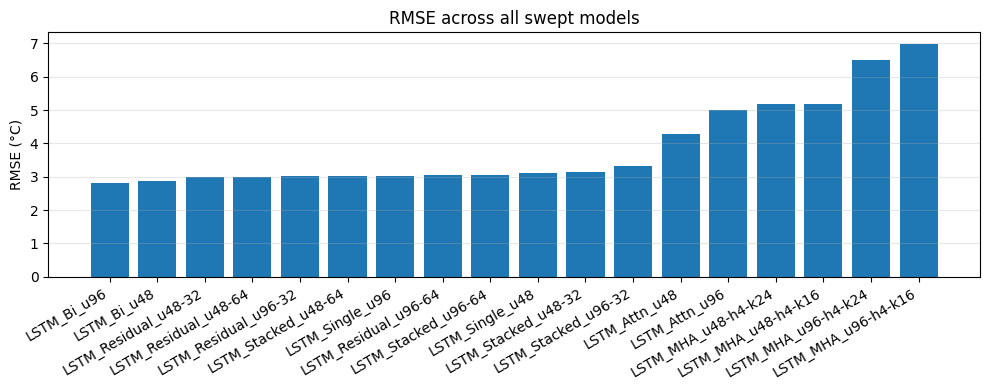

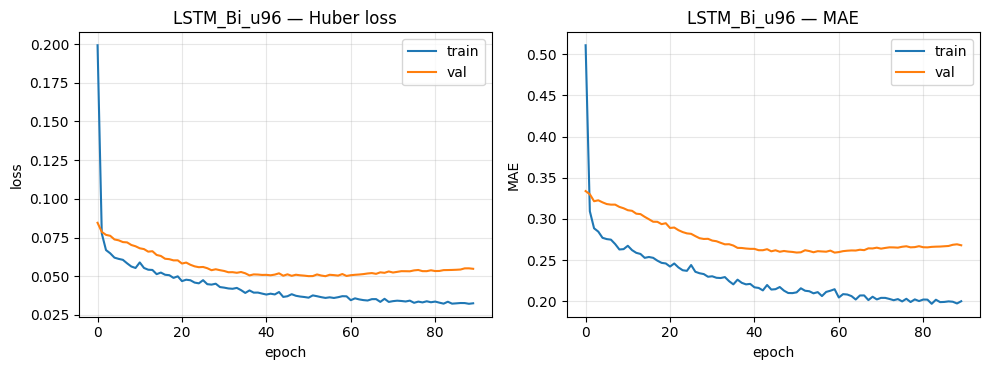

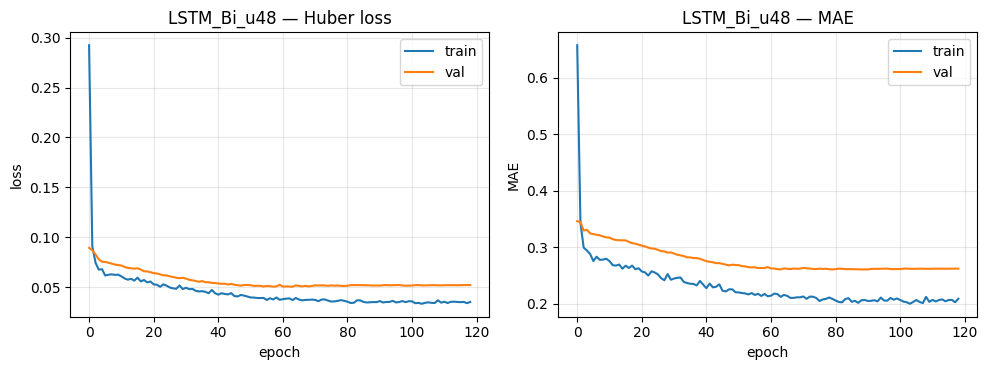

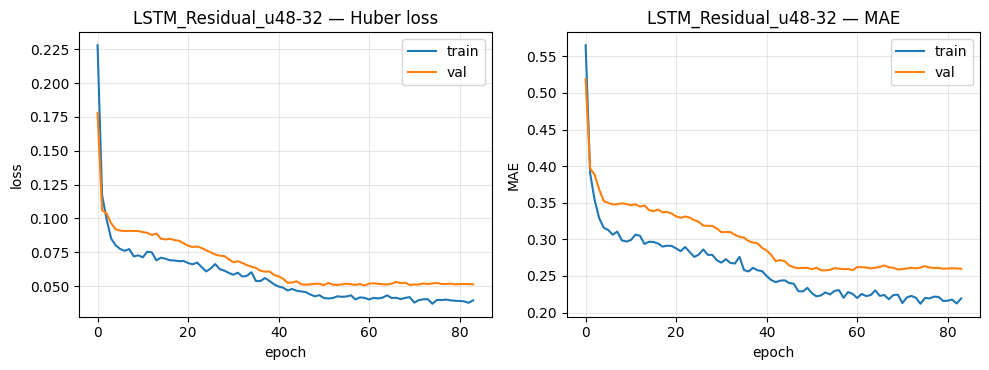

In [65]:
# ==== PLOTS ONLY: choose models and visualize  ====
import matplotlib.pyplot as plt
import numpy as np, pandas as pd

assert 'PRED_BY_MODEL' in globals() and 'HIST_BY_MODEL' in globals(), "Run Cell 1 first."

# If cmp_sweep exists, use it to pick top-K; otherwise build from NEW_RESULTS
if 'cmp_sweep' not in globals():
    assert 'NEW_RESULTS' in globals(), "Need NEW_RESULTS from Cell 1."
    cmp_sweep = pd.DataFrame(NEW_RESULTS).sort_values(["RMSE","MAE"]).reset_index(drop=True)

# ---- selection controls ----
TOPK = 3                      # how many top models to show
SELECT_MODELS = []            # manually list model names to plot; leave [] to use top-K by RMSE

# pick models
if SELECT_MODELS:
    chosen = [m for m in SELECT_MODELS if m in PRED_BY_MODEL]
else:
    chosen = cmp_sweep["Model"].iloc[:min(TOPK, len(cmp_sweep))].tolist()

print("Chosen models:", chosen)


# ----  RMSE bar chart across ALL models (sorted) ----
cmp_all = cmp_sweep.copy()
plt.figure(figsize=(10,4))
x = np.arange(len(cmp_all))
plt.bar(x, cmp_all["RMSE"].values)
plt.xticks(x, cmp_all["Model"].tolist(), rotation=30, ha='right')
plt.ylabel("RMSE (°C)"); plt.title("RMSE across all swept models")
plt.grid(axis="y", alpha=0.3); plt.tight_layout(); plt.show()

# ---- Training curves for chosen models ----
def plot_history_from_dict(hist_dict, title):
    fig, ax = plt.subplots(1, 2, figsize=(10, 3.8))
    ax[0].plot(hist_dict["loss"], label="train"); ax[0].plot(hist_dict["val_loss"], label="val")
    ax[0].set_title(f"{title} — Huber loss"); ax[0].set_xlabel("epoch"); ax[0].set_ylabel("loss"); ax[0].grid(alpha=0.3); ax[0].legend()
    ax[1].plot(hist_dict["mae"],  label="train"); ax[1].plot(hist_dict["val_mae"],  label="val")
    ax[1].set_title(f"{title} — MAE"); ax[1].set_xlabel("epoch"); ax[1].set_ylabel("MAE"); ax[1].grid(alpha=0.3); ax[1].legend()
    plt.tight_layout(); plt.show()

for name in chosen:
    plot_history_from_dict(HIST_BY_MODEL[name], name)


## 19) Combined Results and Best 3 v.s. Actual

We can combine the resultss of our sweep with that of the original test, and graph the top 3 overall results vs the actual temperaaure readings for the test period.

=== Top Sweep Models (sorted by RMSE, MAE) ===


Model       MAE      RMSE        R2      Acc±2      Acc±3  \
0           LSTM_Bi_u96  2.215713  2.811162  0.631679  51.818182  66.363636   
1           LSTM_Bi_u48  2.259676  2.862693  0.618051  50.000000  70.909091   
2  LSTM_Residual_u48-32  2.389556  2.982983  0.585278  50.000000  68.181818   
3  LSTM_Residual_u48-64  2.388127  2.991585  0.582883  50.000000  66.363636   
4  LSTM_Residual_u96-32  2.385027  3.020152  0.574879  49.090909  63.636364   
5   LSTM_Stacked_u48-64  2.386549  3.032458  0.571407  48.181818  65.454545   
6       LSTM_Single_u96  2.386064  3.036530  0.570255  50.000000  67.272727   
7  LSTM_Residual_u96-64  2.390195  3.045336  0.567759  48.181818  62.727273   
8   LSTM_Stacked_u96-64  2.390178  3.062250  0.562945  47.272727  62.727273   
9       LSTM_Single_u48  2.445014  3.121884  0.545756  49.090909  60.000000   

       Acc±5  
0  91.818182  
1  93.636364  
2  90.000000  
3  90.000000  
4  90.000000  
5  90.909091  
6  90.000000  
7  90.000000  
8  90.000000  
9  88.181818

=== All Models So Far ===


Model       MAE      RMSE        R2      Acc±2      Acc±3  \
0            LSTM_Bi_u96  2.215713  2.811162  0.631679  51.818182  66.363636   
1            LSTM_Bi_u48  2.259676  2.862693  0.618051  50.000000  70.909091   
2     LSTM_Bidirectional  2.305944  2.934531  0.598641  53.636364  70.909091   
3   LSTM_Residual_u48-32  2.389556  2.982983  0.585278  50.000000  68.181818   
4   LSTM_Residual_u48-64  2.388127  2.991585  0.582883  50.000000  66.363636   
5           LSTM_Stacked  2.390579  3.007451  0.578447  50.909091  65.454545   
6        LSTM_Single_u96  2.372294  3.007516  0.578429  51.818182  65.454545   
7   LSTM_Residual_u96-32  2.385027  3.020152  0.574879  49.090909  63.636364   
8    LSTM_Stacked_u48-64  2.386549  3.032458  0.571407  48.181818  65.454545   
9        LSTM_Single_u96  2.386064  3.036530  0.570255  50.000000  67.272727   
10  LSTM_Residual_u96-64  2.390195  3.045336  0.567759  48.181818  62.727273   
11         LSTM_Residual  2.399740  3.049992  0.566437  49.090909  63.636364   
12   LSTM_Stacked_u96-64  2.390178  3.062250  0.562945  47.272727  62.727273   
13       LSTM_Single_u48  2.412657  3.102138  0.551485  49.090909  61.818182   
14       LSTM_Single_u48  2.445014  3.121884  0.545756  49.090909  60.000000   
15   LSTM_Stacked_u48-32  2.464059  3.131793  0.542868  46.363636  60.909091   
16       LSTM_Single_u48  2.525794  3.226501  0.514802  47.272727  59.090909   
17   LSTM_Stacked_u96-32  2.670395  3.333538  0.482076  44.545455  60.909091   
18         LSTM_Attn_u48  3.362597  4.271744  0.149517  40.909091  52.727273   
19         LSTM_Attn_u96  4.079899  5.006441 -0.168190  29.090909  43.636364   
20   LSTM_MHA_u48-h4-k24  4.124693  5.169761 -0.245650  29.090909  40.000000   
21   LSTM_MHA_u48-h4-k16  4.151639  5.175600 -0.248466  31.818182  41.818182   
22              LSTM_MHA  4.483351  5.438022 -0.378279  27.272727  41.818182   
23   LSTM_MHA_u96-h4-k24  5.533020  6.487314 -0.961485  20.909091  30.909091   
24   LSTM_MHA_u96-h4-k16  5.914186  6.982999 -1.272685  17.272727  26.363636   
25        LSTM_Attention  5.892623  7.029521 -1.303067  18.181818  24.545455   

        Acc±5  
0   91.818182  
1   93.636364  
2   92.727273  
3   90.000000  
4   90.000000  
5   90.909091  
6   90.000000  
7   90.000000  
8   90.909091  
9   90.000000  
10  90.000000  
11  90.909091  
12  90.000000  
13  89.090909  
14  88.181818  
15  90.000000  
16  90.000000  
17  87.272727  
18  74.545455  
19  65.454545  
20  68.181818  
21  64.545455  
22  60.000000  
23  42.727273  
24  42.727273  
25  47.272727

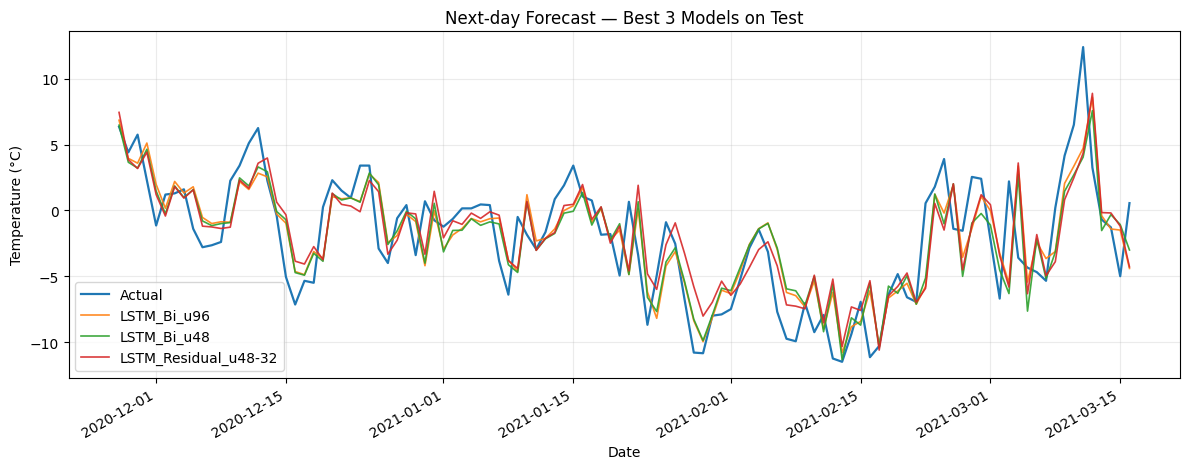

In [66]:
# Summary for the sweep only
cmp_sweep = pd.DataFrame(SWEEP_RESULTS).sort_values(["RMSE","MAE"]).reset_index(drop=True)
print("=== Top Sweep Models (sorted by RMSE, MAE) ===")
display(cmp_sweep.head(10))

# Merge with previous NEW_RESULTS (if not already merged)
cmp_all = pd.DataFrame(NEW_RESULTS).sort_values(["RMSE","MAE"]).reset_index(drop=True)
print("=== All Models So Far ===")
display(cmp_all)

# Optional overlay plot for the best 3 from the sweep
top3_names = cmp_sweep["Model"].iloc[:3].tolist()
plt.figure(figsize=(12,4.8))
plt.plot(Dte, yte, label="Actual", linewidth=1.6)
for name in top3_names:
    plt.plot(Dte, PRED_BY_MODEL[name], label=name, alpha=0.9, linewidth=1.2)

plt.title(f"Next-day Forecast — Best 3 Models on Test")
plt.xlabel("Date"); plt.ylabel("Temperature (°C)")
plt.legend(); plt.grid(alpha=0.25); plt.gcf().autofmt_xdate(); plt.tight_layout(); plt.show()


## 20) Triple-Stacked LSTM

We saw moderate success from our singly-stacked LSTM model **(LSTM_Stacked_u48-64 ,MAE = 2.386549)**

We start with a leyer of just 64 units. and then add 96 units, 48 units, and 128 unitss in series to get a final triply-stacked LSTM Model with shape 128-96-64-48.

In [ ]:
# ===== OOP: Triple-Stacked LSTM (with plots)=====
import numpy as np, matplotlib.pyplot as plt, tensorflow as tf
from dataclasses import dataclass
from tensorflow.keras import layers, Model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ---------------- Config ----------------
@dataclass
class Config:
    """
    Configuration object for the LSTM Triple-Stacked experiment.

    Stores hyperparameters for data handling, model architecture,
    training loop, and reproducibility. Provides a helper method
    to set random seeds.

    Attributes:
        window (int): Input sequence length (timesteps).
        seed (int): Random seed for reproducibility.
        lr (float): Learning rate for Adam optimizer.
        batch_size (int): Mini-batch size for training.
        epochs (int): Maximum training epochs.
        patience_es (int): Patience for EarlyStopping.
        patience_rlr (int): Patience for ReduceLROnPlateau.
        min_lr (float): Minimum learning rate for LR scheduler.
        u1, u2, u3 (int): Units in the three stacked LSTM layers.
        drop1, drop2, drop3 (float): Dropout rates after each LSTM.
        dense_units (int): Units in the dense hidden layer.

    Methods:
        set_seeds(): Clears TF graph and sets seeds for NumPy/TF.
    """
    window: int = 90
    seed: int = 42
    lr: float = 1e-3
    batch_size: int = 64
    epochs: int = 400
    patience_es: int = 30
    patience_rlr: int = 10
    min_lr: float = 1e-5
    # architecture
    u1: int = 128
    u2: int = 96
    u3: int = 64
    drop1: float = 0.20
    drop2: float = 0.20
    drop3: float = 0.25
    dense_units: int = 64

    def set_seeds(self):
        tf.keras.backend.clear_session()
        tf.random.set_seed(self.seed)
        np.random.seed(self.seed)

# ------------- Inverse scaler (uses your train stats) -------------
class InverseScaler:
    """
    Utility class to reverse standardization of model predictions.

    Attributes:
        mean (float): Training-set mean of the target variable.
        std (float): Training-set standard deviation (with epsilon guard).

    Methods:
        iz(x): Inverse-transform standardized values to original scale.
    """
    def __init__(self, mean, std):
        """
    Utility class to reverse standardization of model predictions.

    Attributes:
        mean (float): Training-set mean of the target variable.
        std (float): Training-set standard deviation (with epsilon guard).

    Methods:
        iz(x): Inverse-transform standardized values to original scale.
    """
        self.mean = float(mean)
        self.std  = float(std + 1e-8)
    def iz(self, x):
        """
        Apply inverse transformation.

        Args:
            x (np.ndarray or tf.Tensor): Standardized values.

        Returns:
            np.ndarray or tf.Tensor: Values in original scale.
        """
        return x * self.std + self.mean

# ---------------- Model Builder (3-layer LSTM) ----------------
class LSTMTripleBuilder:
    """
    Builder for a triple-stacked LSTM forecasting model.

    Architecture:
        - LSTM (u1 units, sequence output) + Dropout
        - LSTM (u2 units, sequence output) + Dropout
        - LSTM (u3 units, last state)      + Dropout
        - Dense hidden layer (ReLU)
        - Dense output layer (linear)

    Attributes:
        name (str): Model name identifier ("LSTM_Triple").
        cfg (Config): Configuration object with hyperparameters.

    Methods:
        build() -> Model: Construct and return the compiled Keras model.
    """

    name = "LSTM_Triple"
    def __init__(self, cfg: Config):
        self.cfg = cfg
    def build(self) -> Model:
        w = self.cfg.window
        inp = layers.Input(shape=(w,1))
        # LSTM #1 → sequence
        h   = layers.LSTM(self.cfg.u1, return_sequences=True)(inp)
        h   = layers.Dropout(self.cfg.drop1)(h)
        # LSTM #2 → sequence
        h   = layers.LSTM(self.cfg.u2, return_sequences=True)(h)
        h   = layers.Dropout(self.cfg.drop2)(h)
        # LSTM #3 → last state
        h   = layers.LSTM(self.cfg.u3, return_sequences=False)(h)
        h   = layers.Dropout(self.cfg.drop3)(h)
        # Head
        h   = layers.Dense(self.cfg.dense_units, activation="relu")(h)
        out = layers.Dense(1)(h)
        return Model(inp, out, name=self.name)

# ---------------- Trainer ----------------
class Trainer:
    def __init__(self, cfg: Config):
        self.cfg = cfg
        self.callbacks = [
            tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=cfg.patience_es, mode="min", restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=cfg.patience_rlr, min_lr=cfg.min_lr),
        ]
    def compile(self, model: Model):
        model.compile(optimizer=tf.keras.optimizers.Adam(self.cfg.lr),
                      loss="huber", metrics=["mae"])
        return model
    def fit(self, model: Model, Xtr, ytr, Xva, yva):
        hist = model.fit(Xtr, ytr, validation_data=(Xva, yva),
                         epochs=self.cfg.epochs, batch_size=self.cfg.batch_size,
                         verbose=1, callbacks=self.callbacks)
        return hist
    def predict(self, model: Model, X):
        return model.predict(X, batch_size=256, verbose=0).reshape(-1)

# ---------------- Evaluator ----------------
class Evaluator:
    """
    Provides evaluation utilities for regression tasks.

    Static Methods:
        acc_tol(y, yhat, k): Accuracy within ±k tolerance.
        summarize(y_true, y_pred): Compute MAE, RMSE, R², and tolerance accuracies.
    """
    @staticmethod
    def acc_tol(y, yhat, k):
        """
        Compute tolerance accuracy.

        Args:
            y (np.ndarray): Ground-truth targets.
            yhat (np.ndarray): Predicted targets.
            k (float): Tolerance threshold.

        Returns:
            float: Fraction of predictions within ±k of true values.
        """
        return float(np.mean(np.abs(y - yhat) <= k))
    @staticmethod
    def summarize(y_true, y_pred):
        """
        Summarize regression performance metrics.

        Args:
            y_true (np.ndarray): Ground-truth targets.
            y_pred (np.ndarray): Predicted targets.

        Returns:
            dict: {"Model","MAE","RMSE","R2","Acc±2","Acc±3","Acc±5"}.
        """
        mae  = float(mean_absolute_error(y_true, y_pred))
        rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
        r2   = float(r2_score(y_true, y_pred))
        a2   = 100 * Evaluator.acc_tol(y_true, y_pred, 2.0)
        a3   = 100 * Evaluator.acc_tol(y_true, y_pred, 3.0)
        a5   = 100 * Evaluator.acc_tol(y_true, y_pred, 5.0)
        return {"Model":"LSTM_Triple","MAE":mae,"RMSE":rmse,"R2":r2,"Acc±2":a2,"Acc±3":a3,"Acc±5":a5}

# ---------------- Plotter ----------------
class Plotter:
    """
    Provides static plotting utilities for training curves and test overlays.

    Static Methods:
        history(hist, title): Plot training vs. validation loss/MAE curves.
        test_overlay(Dte, yte, yhat, title): Plot actual vs. predicted test series.
    """
    @staticmethod
    def history(hist, title):
        """
        Plot Huber loss and MAE curves.

        Args:
            hist (tf.keras.callbacks.History): Training history object.
            title (str): Model name/title for the plots.

        Returns:
            None: Displays matplotlib figure.
        """
        h = hist.history
        fig, ax = plt.subplots(1, 2, figsize=(10, 3.8))
        ax[0].plot(h["loss"], label="train"); ax[0].plot(h["val_loss"], label="val")
        ax[0].set_title(f"{title} — Huber loss"); ax[0].set_xlabel("epoch"); ax[0].set_ylabel("loss"); ax[0].grid(alpha=0.3); ax[0].legend()
        ax[1].plot(h["mae"], label="train"); ax[1].plot(h["val_mae"], label="val")
        ax[1].set_title(f"{title} — MAE"); ax[1].set_xlabel("epoch"); ax[1].set_ylabel("MAE"); ax[1].grid(alpha=0.3); ax[1].legend()
        plt.tight_layout(); plt.show()

    @staticmethod
    def test_overlay(Dte, yte, yhat, title):
        """
        Overlay actual vs. predicted test series.

        Args:
            Dte (array-like): Test dates (x-axis).
            yte (np.ndarray): Ground-truth values.
            yhat (np.ndarray): Predicted values.
            title (str): Label for the predicted series.

        Returns:
            None: Displays matplotlib figure.
        """
        plt.figure(figsize=(12,4.6))
        plt.plot(Dte, yte,  label="Actual", linewidth=1.6)
        plt.plot(Dte, yhat, label=title,   linewidth=1.4)
        plt.title(f"Next-day Forecast — {title} (Test)")
        plt.xlabel("Date"); plt.ylabel("Temperature (°C)")
        plt.legend(); plt.grid(alpha=0.25); plt.gcf().autofmt_xdate(); plt.tight_layout(); plt.show()


## 21 Triple Stack Test

0	LSTM_Stack_u128-96-64 (MAE: 2.397687)
1	LSTM_Stack_u96-64 (MAE: 2.429507)
2	LSTM_Stack_u64 (MAE: 2.486448)
3	LSTM_Stack_u128-96-64-48 (MAE: 3.525801)

Three layesrs appeared to perform the best, overfitting may have occured with 4 layers. More layers (from 1 to 2 to 3), does stend to help overall. Possible that more vigorous dropout could be used to avoid overfitting.

In [61]:
# ===== Depth sweep for stacked LSTM  =====
import re, numpy as np, pandas as pd, tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Assumes these exist from your preprocessing:
# w, Xtr_s, ytr_s, Xva_s, yva_s, Xte_s, yte, tr_mean, tr_std

tf.keras.backend.clear_session()
tf.random.set_seed(42); np.random.seed(42)

# ---- helpers (no plotting here) ----
def _safe_name(s: str) -> str:
    s = re.sub(r'[^A-Za-z0-9._\/>\-]+', '_', s)
    if not re.match(r'^[A-Za-z0-9.]', s): s = 'M' + s
    return s

def iz(x):  # inverse-standardize using train stats
    return x * (tr_std + 1e-8) + tr_mean

def evaluate_on_test_no_plot(model):
    yhat_s = model.predict(Xte_s, batch_size=256, verbose=0).reshape(-1)
    yhat   = iz(yhat_s)
    mae  = float(mean_absolute_error(yte, yhat))
    rmse = float(np.sqrt(mean_squared_error(yte, yhat)))
    r2   = float(r2_score(yte, yhat))
    a2   = 100*float(np.mean(np.abs(yte - yhat) <= 2.0))
    a3   = 100*float(np.mean(np.abs(yte - yhat) <= 3.0))
    a5   = 100*float(np.mean(np.abs(yte - yhat) <= 5.0))
    return {"Model": model.name, "MAE": mae, "RMSE": rmse, "R2": r2, "Acc±2": a2, "Acc±3": a3, "Acc±5": a5}, yhat

def compile_and_fit_hist_SAFE(model, Xtr, ytr, Xva, yva, epochs=400, batch_size=64):
    model._name = _safe_name(model.name)  # ensure TF-safe root scope
    assert '(' not in model.name and ')' not in model.name
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss="huber", metrics=["mae"])
    cb = [
        tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=30, mode="min", restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, min_lr=1e-5),
    ]
    hist = model.fit(Xtr, ytr, validation_data=(Xva, yva),
                     epochs=epochs, batch_size=batch_size, verbose=1, callbacks=cb)
    return model, hist

# ---- builder (safe model names; no parentheses) ----
def build_stacked_lstm_safe(units_list, w, drop_mid=0.20, drop_last=0.25, dense_units=64):
    """
    units_list: e.g. [64] | [96,64] | [128,96,64] | [128,96,64,48]
    """
    inp = layers.Input(shape=(w,1))
    x = inp
    for u in units_list[:-1]:
        x = layers.LSTM(u, return_sequences=True)(x)
        x = layers.Dropout(drop_mid)(x)
    x = layers.LSTM(units_list[-1], return_sequences=False)(x)
    x = layers.Dropout(drop_last)(x)
    x = layers.Dense(dense_units, activation="relu")(x)
    out = layers.Dense(1)(x)
    safe_name = _safe_name("LSTM_Stack_u" + "-".join(str(u) for u in units_list))
    return Model(inp, out, name=safe_name)

# ---- configurations (display tags may keep parentheses for readability) ----
DEPTH_CONFIGS = {
    "L1(64)"            : [64],
    "L2(96-64)"         : [96, 64],
    "L3(128-96-64)"     : [128, 96, 64],
    "L4(128-96-64-48)"  : [128, 96, 64, 48],
}

# ---- TRAIN ONLY: run sweep, collect artifacts (no plots) ----
DEPTH_RESULTS   = []
DEPTH_PREDICTS  = {}
HIST_BY_DEPTH   = {}   # training curves per depth tag

for tag, units_list in DEPTH_CONFIGS.items():
    model = build_stacked_lstm_safe(units_list, w)
    print("Training:", model.name)  # e.g., LSTM_Stack_u96-64
    model, hist = compile_and_fit_hist_SAFE(model, Xtr_s, ytr_s, Xva_s, yva_s, epochs=400, batch_size=64)
    m, yhat = evaluate_on_test_no_plot(model)
    m["DepthTag"] = tag
    DEPTH_RESULTS.append(m)
    DEPTH_PREDICTS[tag] = yhat
    HIST_BY_DEPTH[tag]  = hist.history  # store curves only

# summary table (no plots)
cmp_depth = pd.DataFrame(DEPTH_RESULTS).sort_values(["RMSE","MAE"]).reset_index(drop=True)
display(cmp_depth)


Training: LSTM_Stack_u64
Epoch 1/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.3407 - mae: 0.7216 - val_loss: 0.1051 - val_mae: 0.3913 - learning_rate: 0.0010
Epoch 2/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0851 - mae: 0.3306 - val_loss: 0.0773 - val_mae: 0.3289 - learning_rate: 0.0010
Epoch 3/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0721 - mae: 0.2977 - val_loss: 0.0831 - val_mae: 0.3427 - learning_rate: 0.0010
Epoch 4/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0638 - mae: 0.2839 - val_loss: 0.0758 - val_mae: 0.3265 - learning_rate: 0.0010
Epoch 5/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 0.0610 - mae: 0.2756 - val_loss: 0.0783 - val_mae: 0.3326 - learning_rate: 0.0010
Epoch 6/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - loss: 0.0596 - mae: 0.2702 - val_loss: 0.0748 - val_mae: 0.3238 - learning_rate: 0.0010
Epoch 7/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0564 - mae: 0.2637 - val_loss: 0.0739 - val_mae: 0.3216 - le

Model       MAE      RMSE        R2      Acc±2  \
0     LSTM_Stack_u128-96-64  2.397687  2.971715  0.588405  49.090909   
1         LSTM_Stack_u96-64  2.429507  3.089888  0.555020  46.363636   
2            LSTM_Stack_u64  2.486448  3.170079  0.531623  48.181818   
3  LSTM_Stack_u128-96-64-48  3.525801  4.294437  0.140457  33.636364   

       Acc±3      Acc±5          DepthTag  
0  67.272727  92.727273     L3(128-96-64)  
1  62.727273  89.090909         L2(96-64)  
2  60.000000  89.090909            L1(64)  
3  48.181818  73.636364  L4(128-96-64-48)

## 22) Stacked LSTM Comparison Graphs

Here we graph each of our 3 best sstacked models v.s. the actual temperatures. We also graph RMSE by depth, and Huber losss and MAE for our top 3 models. We then compare the absolute error between the best and worst satcked models.

Chosen depths: ['L3(128-96-64)', 'L2(96-64)', 'L1(64)']


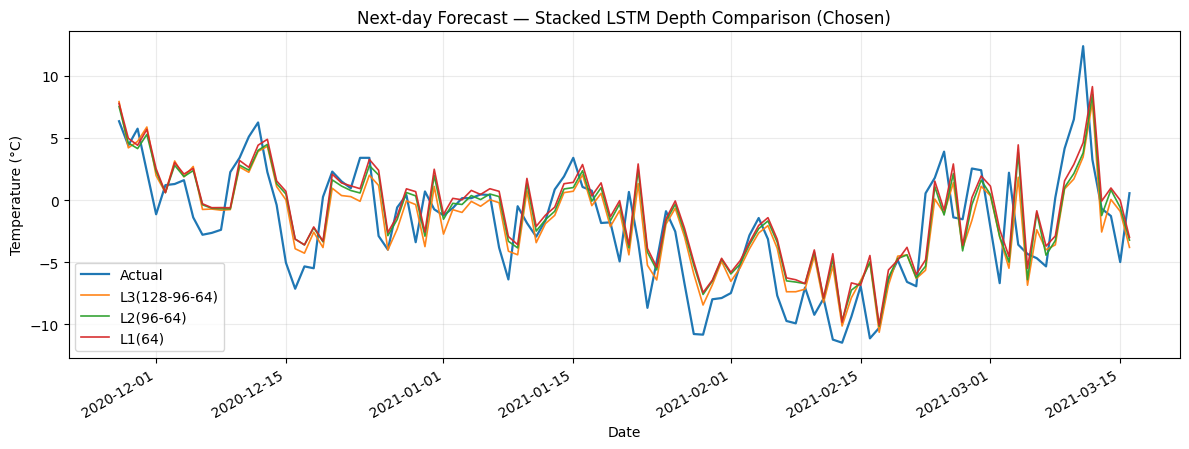

In [83]:
# ===== PLOTS ONLY for depth sweep (uses artifacts from Cell 1) =====
import matplotlib.pyplot as plt
import numpy as np, pandas as pd

# Must run Cell 1 first
assert all(k in globals() for k in ["DEPTH_RESULTS","DEPTH_PREDICTS","HIST_BY_DEPTH","cmp_depth","yte","Dte"])

# ---- choose which depths to visualize ----
TOPK = 3
SELECT_TAGS = []   # e.g. ["L2(96-64)", "L3(128-96-64)"]; leave [] to auto-pick top-K by RMSE

if SELECT_TAGS:
    chosen_tags = [t for t in SELECT_TAGS if t in DEPTH_PREDICTS]
else:
    chosen_tags = cmp_depth["DepthTag"].iloc[:min(TOPK, len(cmp_depth))].tolist()

print("Chosen depths:", chosen_tags)

# 1) Overlay predictions on test
plt.figure(figsize=(12,4.6))
plt.plot(Dte, yte, label="Actual", linewidth=1.6)
for tag in chosen_tags:
    plt.plot(Dte, DEPTH_PREDICTS[tag], label=tag, linewidth=1.2, alpha=0.95)
plt.title("Next-day Forecast — Stacked LSTM Depth Comparison (Chosen)")
plt.xlabel("Date"); plt.ylabel("Temperature (°C)")
plt.legend(); plt.grid(alpha=0.25); plt.gcf().autofmt_xdate(); plt.tight_layout(); plt.show()




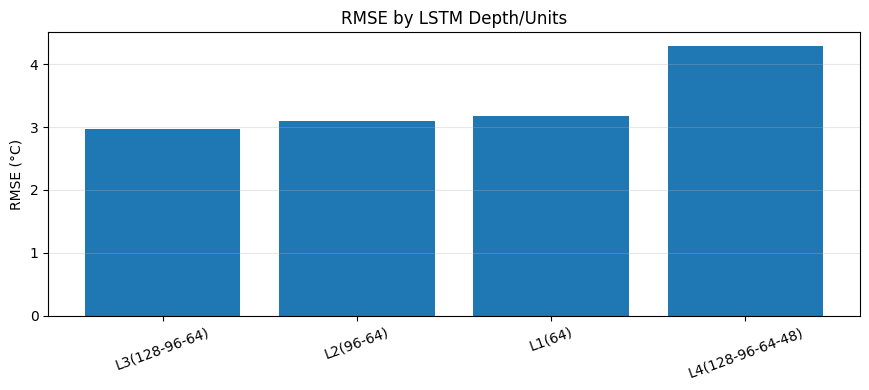

In [84]:
#  RMSE bar chart across all depths
plt.figure(figsize=(8.8,4))
x = np.arange(len(cmp_depth))
plt.bar(x, cmp_depth["RMSE"].values)
plt.xticks(x, cmp_depth["DepthTag"].tolist(), rotation=20)
plt.ylabel("RMSE (°C)"); plt.title("RMSE by LSTM Depth/Units")
plt.grid(axis="y", alpha=0.3); plt.tight_layout(); plt.show()


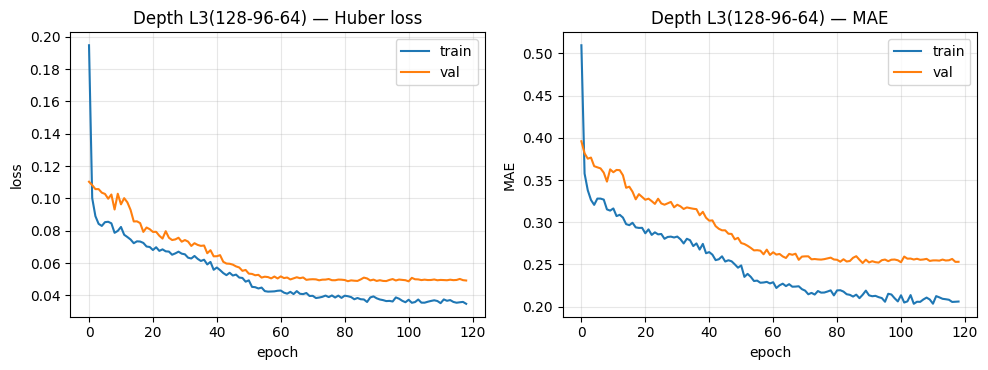

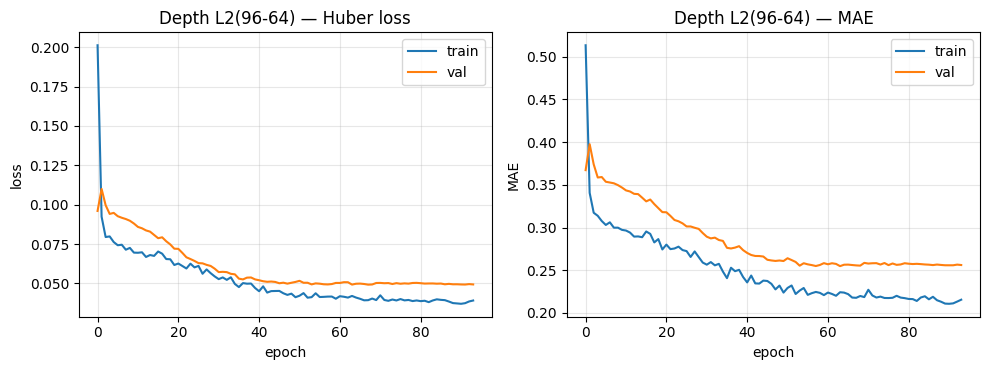

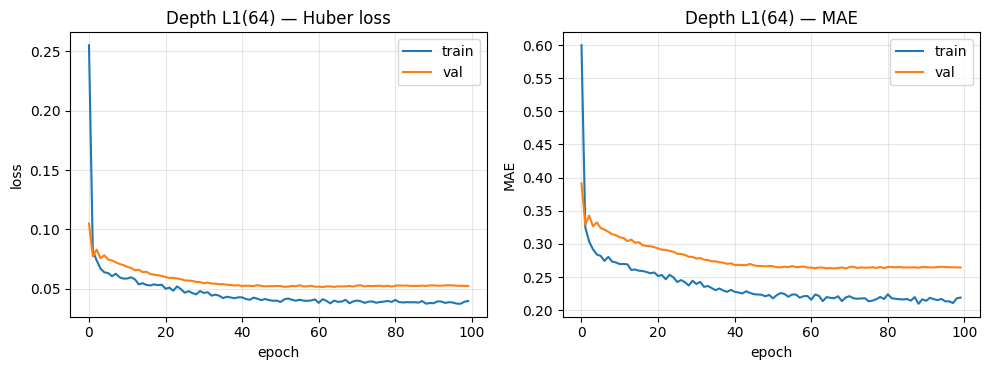

In [ ]:

#  Training curves (loss/MAE) for chosen depths
def plot_history_from_dict(hist_dict, title):
    """
    Plot training and validation curves from a stored history dictionary.

    Designed for cases where only the history dictionary (and not the full
    tf.keras.callbacks.History object) is available.

    Args:
        hist_dict (dict): Dictionary containing keys:
            - "loss": list of training losses
            - "val_loss": list of validation losses
            - "mae": list of training mean absolute errors
            - "val_mae": list of validation mean absolute errors
        title (str): Title prefix for the subplots.

    Returns:
        None: Displays matplotlib plots of training vs validation loss and MAE.
    """
    fig, ax = plt.subplots(1, 2, figsize=(10, 3.8))
    ax[0].plot(hist_dict["loss"], label="train"); ax[0].plot(hist_dict["val_loss"], label="val")
    ax[0].set_title(f"{title} — Huber loss"); ax[0].set_xlabel("epoch"); ax[0].set_ylabel("loss"); ax[0].grid(alpha=0.3); ax[0].legend()
    ax[1].plot(hist_dict["mae"],  label="train"); ax[1].plot(hist_dict["val_mae"],  label="val")
    ax[1].set_title(f"{title} — MAE"); ax[1].set_xlabel("epoch"); ax[1].set_ylabel("MAE"); ax[1].grid(alpha=0.3); ax[1].legend()
    plt.tight_layout(); plt.show()

for tag in chosen_tags:
    plot_history_from_dict(HIST_BY_DEPTH[tag], f"Depth {tag}")


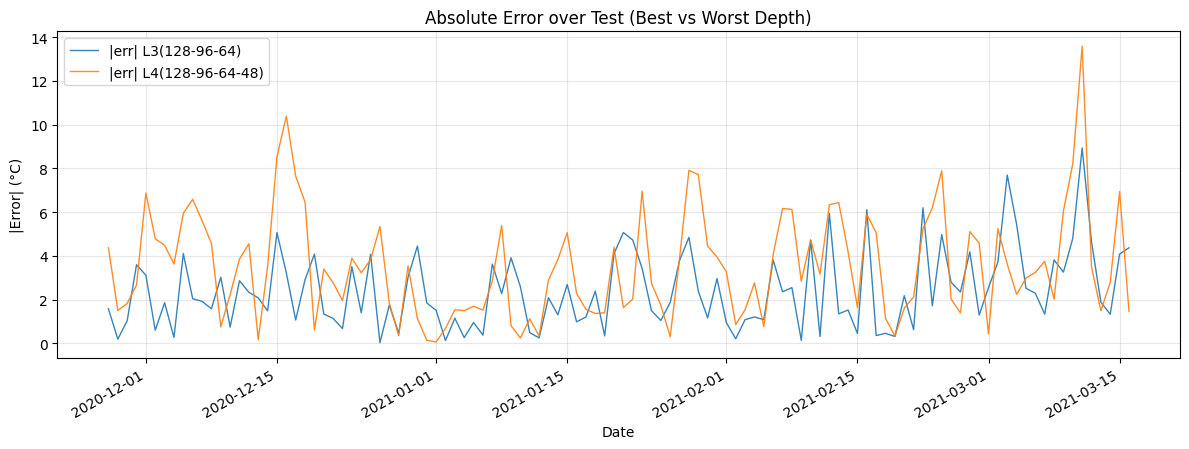

In [88]:
import matplotlib.pyplot as plt
import numpy as np

# Overlay (top 3)
topk = min(3, len(DEPTH_PREDICTS))
topk_tags = cmp_depth["DepthTag"].iloc[:topk].tolist()


# Absolute error comparison (best vs worst)
best_tag  = cmp_depth["DepthTag"].iloc[0]
worst_tag = cmp_depth["DepthTag"].iloc[-1] if len(cmp_depth)>1 else best_tag
abs_err_best  = np.abs(yte - DEPTH_PREDICTS[best_tag])
abs_err_worst = np.abs(yte - DEPTH_PREDICTS[worst_tag])

plt.figure(figsize=(12,4.6))
plt.plot(Dte, abs_err_best,  label=f"|err| {best_tag}",  linewidth=1.0, alpha=0.9)
plt.plot(Dte, abs_err_worst, label=f"|err| {worst_tag}", linewidth=1.0, alpha=0.9)
plt.title("Absolute Error over Test (Best vs Worst Depth)")
plt.xlabel("Date"); plt.ylabel("|Error| (°C)")
plt.legend(); plt.grid(alpha=0.3); plt.gcf().autofmt_xdate(); plt.tight_layout(); plt.show()


## 23) Simple RNN Models

We train three simple RNN models, a bidirectional, a singly stacked, and a single model.

In [68]:
# ===== Simple RNN baselines  =====
import re, numpy as np, pandas as pd, tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Assumes these exist from your preprocessing:
# w, Xtr_s, ytr_s, Xva_s, yva_s, Xte_s, yte, tr_mean, tr_std

tf.keras.backend.clear_session()
tf.random.set_seed(42); np.random.seed(42)

# ---- helpers ----
def _safe_name(s: str) -> str:
    s = re.sub(r'[^A-Za-z0-9._\/>\-]+', '_', s)
    if not re.match(r'^[A-Za-z0-9.]', s): s = 'M' + s
    return s

def iz(x):  # inverse-standardize using train stats
    return x * (tr_std + 1e-8) + tr_mean

def evaluate_on_test_no_plot(model):
    yhat_s = model.predict(Xte_s, batch_size=256, verbose=0).reshape(-1)
    yhat   = iz(yhat_s)
    mae  = float(mean_absolute_error(yte, yhat))
    rmse = float(np.sqrt(mean_squared_error(yte, yhat)))
    r2   = float(r2_score(yte, yhat))
    a2   = 100*float(np.mean(np.abs(yte - yhat) <= 2.0))
    a3   = 100*float(np.mean(np.abs(yte - yhat) <= 3.0))
    a5   = 100*float(np.mean(np.abs(yte - yhat) <= 5.0))
    return {"Model": model.name, "MAE": mae, "RMSE": rmse, "R2": r2, "Acc±2": a2, "Acc±3": a3, "Acc±5": a5}, yhat

def compile_and_fit_hist_SAFE(model, Xtr, ytr, Xva, yva, epochs=400, batch_size=64):
    model._name = _safe_name(model.name)                  # ensure TF-safe root scope
    assert '(' not in model.name and ')' not in model.name
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss="huber", metrics=["mae"])
    cb = [
        tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=30, mode="min", restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, min_lr=1e-5),
    ]
    hist = model.fit(Xtr, ytr, validation_data=(Xva, yva),
                     epochs=epochs, batch_size=batch_size, verbose=1, callbacks=cb)
    return model, hist

# ---- SAFE builders (no parentheses in names) ----
def build_rnn_single_safe(w, units=64, drop=0.25, dense_units=64, name_suffix=""):
    inp = layers.Input(shape=(w,1))
    x   = layers.SimpleRNN(units, return_sequences=False)(inp)
    x   = layers.Dropout(drop)(x)
    x   = layers.Dense(dense_units, activation="relu")(x)
    out = layers.Dense(1)(x)
    return Model(inp, out, name=_safe_name(f"RNN_Single_u{units}{name_suffix}"))

def build_rnn_stacked_safe(w, units1=96, units2=64, drop1=0.20, drop2=0.25, dense_units=64, name_suffix=""):
    inp = layers.Input(shape=(w,1))
    x   = layers.SimpleRNN(units1, return_sequences=True)(inp)
    x   = layers.Dropout(drop1)(x)
    x   = layers.SimpleRNN(units2, return_sequences=False)(x)
    x   = layers.Dropout(drop2)(x)
    x   = layers.Dense(dense_units, activation="relu")(x)
    out = layers.Dense(1)(x)
    return Model(inp, out, name=_safe_name(f"RNN_Stacked_u{units1}-{units2}{name_suffix}"))

def build_rnn_bidir_safe(w, units=64, drop=0.25, dense_units=64, name_suffix=""):
    inp = layers.Input(shape=(w,1))
    x   = layers.Bidirectional(layers.SimpleRNN(units, return_sequences=False))(inp)
    x   = layers.Dropout(drop)(x)
    x   = layers.Dense(dense_units, activation="relu")(x)
    out = layers.Dense(1)(x)
    return Model(inp, out, name=_safe_name(f"RNN_Bidirectional_u{units}{name_suffix}"))

# ---- TRAIN ONLY: run the three RNN variants ----
RNN_RESULTS  = []
RNN_PREDICTS = {}
HIST_BY_RNN  = {}

# Single
rnn_single = build_rnn_single_safe(w, units=64)
print("Training:", rnn_single.name)
rnn_single, hist_single = compile_and_fit_hist_SAFE(rnn_single, Xtr_s, ytr_s, Xva_s, yva_s, epochs=400, batch_size=64)
m_single, yhat_single = evaluate_on_test_no_plot(rnn_single)
RNN_RESULTS.append(m_single); RNN_PREDICTS[rnn_single.name] = yhat_single; HIST_BY_RNN[rnn_single.name] = hist_single.history

# Stacked
rnn_stacked = build_rnn_stacked_safe(w, units1=96, units2=64)
print("Training:", rnn_stacked.name)
rnn_stacked, hist_stacked = compile_and_fit_hist_SAFE(rnn_stacked, Xtr_s, ytr_s, Xva_s, yva_s, epochs=400, batch_size=64)
m_stacked, yhat_stacked = evaluate_on_test_no_plot(rnn_stacked)
RNN_RESULTS.append(m_stacked); RNN_PREDICTS[rnn_stacked.name] = yhat_stacked; HIST_BY_RNN[rnn_stacked.name] = hist_stacked.history

# Bidirectional
rnn_bi = build_rnn_bidir_safe(w, units=64)
print("Training:", rnn_bi.name)
rnn_bi, hist_bi = compile_and_fit_hist_SAFE(rnn_bi, Xtr_s, ytr_s, Xva_s, yva_s, epochs=400, batch_size=64)
m_bi, yhat_bi = evaluate_on_test_no_plot(rnn_bi)
RNN_RESULTS.append(m_bi); RNN_PREDICTS[rnn_bi.name] = yhat_bi; HIST_BY_RNN[rnn_bi.name] = hist_bi.history

# Summary table (no plots in this cell)
cmp_rnn = pd.DataFrame(RNN_RESULTS).sort_values(["RMSE","MAE"]).reset_index(drop=True)
display(cmp_rnn)


Training: RNN_Single_u64
Epoch 1/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - loss: 0.2389 - mae: 0.5679 - val_loss: 0.1231 - val_mae: 0.3937 - learning_rate: 0.0010
Epoch 2/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0851 - mae: 0.3325 - val_loss: 0.0786 - val_mae: 0.3216 - learning_rate: 0.0010
Epoch 3/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0657 - mae: 0.2812 - val_loss: 0.0675 - val_mae: 0.3011 - learning_rate: 0.0010
Epoch 4/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0603 - mae: 0.2702 - val_loss: 0.0568 - val_mae: 0.2762 - learning_rate: 0.0010
Epoch 5/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0517 - mae: 0.2530 - val_loss: 0.0575 - val_mae: 0.2780 - learning_rate: 0.0010
Epoch 6/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0482 - mae: 0.2414 - val_loss: 0.0565 - val_mae: 0.2741 - learning_rate: 0.0010
Epoch 7/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0456 - mae: 0.2332 - val_loss: 0.0565 - val_mae: 0.2751 - le

Model       MAE      RMSE        R2      Acc±2      Acc±3  \
0     RNN_Stacked_u96-64  2.520235  3.203783  0.521611  48.181818  62.727273   
1  RNN_Bidirectional_u64  2.615024  3.207084  0.520624  41.818182  64.545455   
2         RNN_Single_u64  2.632245  3.249923  0.507732  43.636364  61.818182   

       Acc±5  
0  87.272727  
1  90.909091  
2  88.181818

## 24) RNN Graphs

We graph:
- RNN v.s. actual
- RMSE of RNN variants
- Huber loss and MSE of RNN Variants

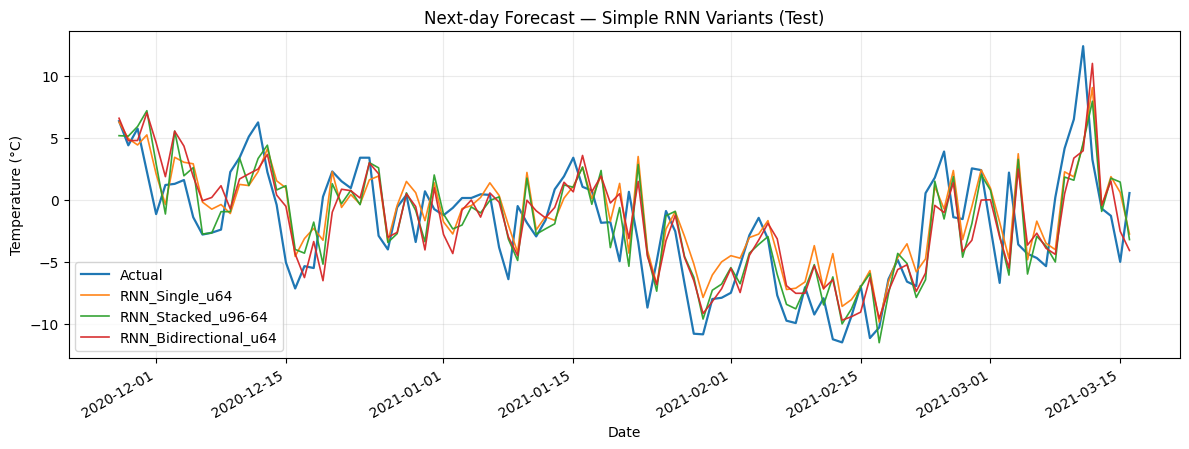

In [74]:
# ===== Simple RNN baselines =====
import matplotlib.pyplot as plt
import numpy as np, pandas as pd

# Requires: RNN_PREDICTS, HIST_BY_RNN, cmp_rnn, yte, Dte
assert all(k in globals() for k in ["RNN_PREDICTS","HIST_BY_RNN","cmp_rnn","yte","Dte"])

# 1) Overlay (all RNN variants)
plt.figure(figsize=(12,4.6))
plt.plot(Dte, yte, label="Actual", linewidth=1.6)
for name, yhat in RNN_PREDICTS.items():
    plt.plot(Dte, yhat, label=name, linewidth=1.2, alpha=0.95)
plt.title("Next-day Forecast — Simple RNN Variants (Test)")
plt.xlabel("Date"); plt.ylabel("Temperature (°C)")
plt.legend(); plt.grid(alpha=0.25); plt.gcf().autofmt_xdate(); plt.tight_layout(); plt.show()




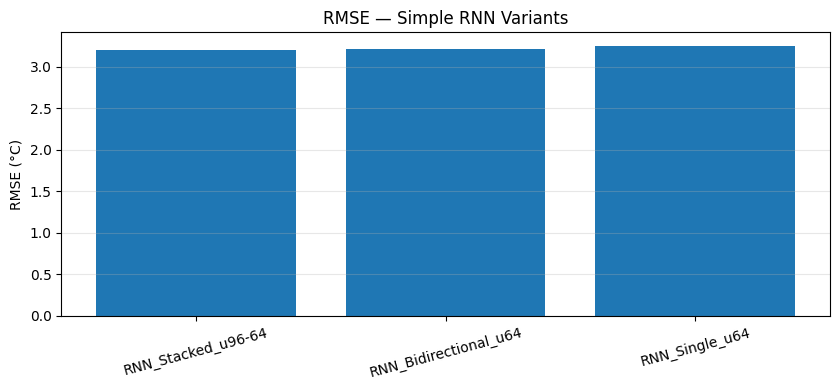

In [75]:
#  RMSE bar chart
plt.figure(figsize=(8.5,4))
x = np.arange(len(cmp_rnn))
plt.bar(x, cmp_rnn["RMSE"].values)
plt.xticks(x, cmp_rnn["Model"].tolist(), rotation=15)
plt.ylabel("RMSE (°C)"); plt.title("RMSE — Simple RNN Variants")
plt.grid(axis="y", alpha=0.3); plt.tight_layout(); plt.show()


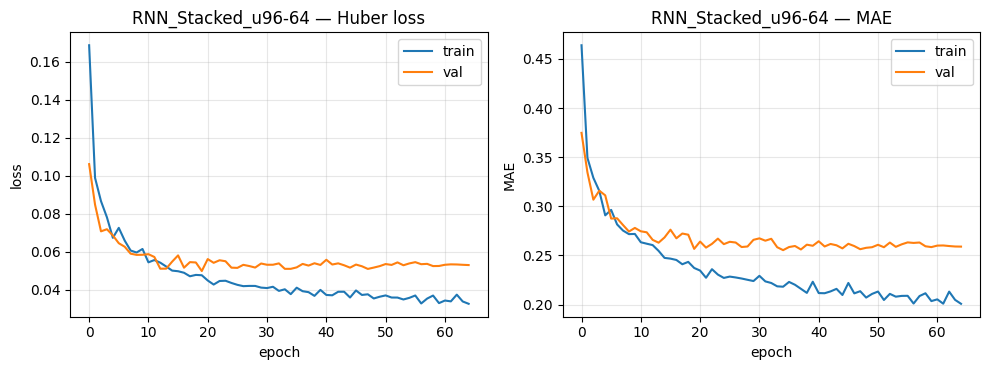

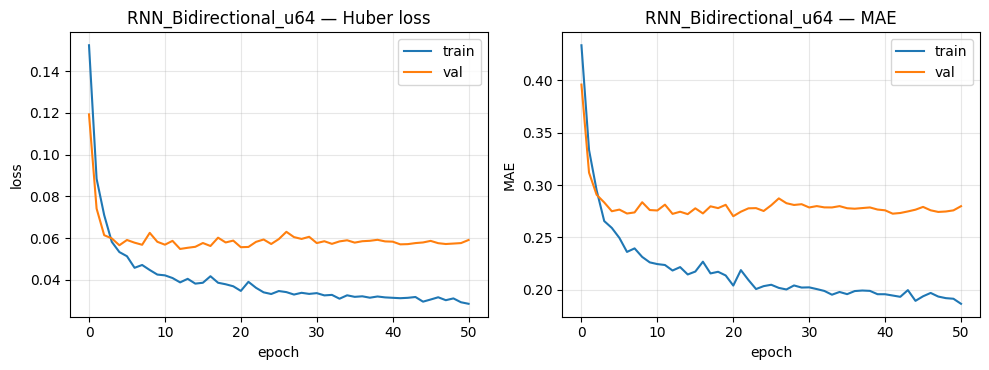

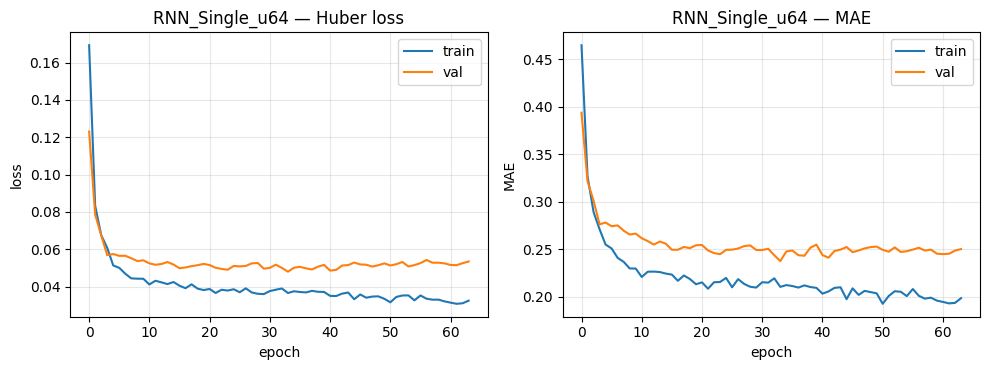

In [77]:
# Training curves (loss/MAE) for all RNN variants
import matplotlib.pyplot as plt

def plot_history_from_dict(hist_dict, title):
    fig, ax = plt.subplots(1, 2, figsize=(10, 3.8))
    ax[0].plot(hist_dict["loss"],     label="train")
    ax[0].plot(hist_dict["val_loss"], label="val")
    ax[0].set_title(f"{title} — Huber loss")
    ax[0].set_xlabel("epoch"); ax[0].set_ylabel("loss")
    ax[0].grid(alpha=0.3); ax[0].legend()

    ax[1].plot(hist_dict["mae"],     label="train")
    ax[1].plot(hist_dict["val_mae"], label="val")
    ax[1].set_title(f"{title} — MAE")
    ax[1].set_xlabel("epoch"); ax[1].set_ylabel("MAE")
    ax[1].grid(alpha=0.3); ax[1].legend()

    plt.tight_layout(); plt.show()

for name in cmp_rnn["Model"].tolist():
    plot_history_from_dict(HIST_BY_RNN[name], name)


## 25) RNN v.s. LSTM Comparison

We compare our simpler RNN Modelss with our best and worst LSTM models to see how they compare.

In [72]:
# ==== LSTM vs RNN:  ====
import re, numpy as np, pandas as pd, tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- sanity (assumed from your preprocessing) ---
assert all(k in globals() for k in ["w","Xtr_s","ytr_s","Xva_s","yva_s","Xte_s","yte","Dte","tr_mean","tr_std"]), \
       "Preprocessing tensors or scaler stats are missing."

tf.keras.backend.clear_session()
tf.random.set_seed(42); np.random.seed(42)

# ---------- helpers ----------
def _safe_name(s: str) -> str:
    s = re.sub(r'[^A-Za-z0-9._\/>\-]+', '_', s)
    if not re.match(r'^[A-Za-z0-9.]', s): s = 'M' + s
    return s

def iz(x):  # inverse-standardize with train stats
    return x * (tr_std + 1e-8) + tr_mean

def acc_within(y, yhat, k):
    return float(np.mean(np.abs(y - yhat) <= k))

def evaluate_no_plot(model):
    yhat_s = model.predict(Xte_s, batch_size=256, verbose=0).reshape(-1)
    yhat   = iz(yhat_s)
    mae  = float(mean_absolute_error(yte, yhat))
    rmse = float(np.sqrt(mean_squared_error(yte, yhat)))
    r2   = float(r2_score(yte, yhat))
    a2   = 100*acc_within(yte, yhat, 2.0)
    a3   = 100*acc_within(yte, yhat, 3.0)
    a5   = 100*acc_within(yte, yhat, 5.0)
    return {"Model": model.name, "MAE": mae, "RMSE": rmse, "R2": r2,
            "AccWithin2C": a2, "AccWithin3C": a3, "AccWithin5C": a5}, yhat

def compile_and_fit_hist_SAFE(model, Xtr, ytr, Xva, yva, epochs=200, batch_size=64):
    model._name = _safe_name(model.name)              # ensure TF-safe root scope
    assert '(' not in model.name and ')' not in model.name
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss="huber", metrics=["mae"])
    cb = [
        tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=30, mode="min", restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, min_lr=1e-5),
    ]
    hist = model.fit(Xtr, ytr, validation_data=(Xva, yva),
                     epochs=epochs, batch_size=batch_size, verbose=1, callbacks=cb)
    return model, hist

# ---------- attention layer for LSTM(attn) ----------
class AdditiveAttention(layers.Layer):
    def __init__(self, units=64):
        super().__init__()
        self.W = layers.Dense(units, use_bias=False)
        self.V = layers.Dense(1,    use_bias=False)
    def call(self, H):
        score = self.V(tf.nn.tanh(self.W(H)))      # (B,T,1)
        alpha = tf.nn.softmax(score, axis=1)        # (B,T,1)
        return tf.reduce_sum(alpha * H, axis=1)     # (B,D)

# ---------- LSTM builders ----------
def build_lstm(arch, w, units1=96, units2=64, dropout1=0.20, dropout2=0.25, num_heads=4, key_dim=16):
    inp = layers.Input(shape=(w,1))
    if arch == "single":
        x = layers.LSTM(units1)(inp)
        x = layers.Dropout(dropout2)(x)
        x = layers.Dense(64, activation="relu")(x)
        out = layers.Dense(1)(x)
        name = f"LSTM_Single_u{units1}"

    elif arch == "stacked":
        x = layers.LSTM(units1, return_sequences=True)(inp)
        x = layers.Dropout(dropout1)(x)
        x = layers.LSTM(units2)(x)
        x = layers.Dropout(dropout2)(x)
        x = layers.Dense(64, activation="relu")(x)
        out = layers.Dense(1)(x)
        name = f"LSTM_Stacked_u{units1}-{units2}"

    elif arch == "bidir":
        x = layers.Bidirectional(layers.LSTM(units1))(inp)
        x = layers.Dropout(dropout2)(x)
        x = layers.Dense(64, activation="relu")(x)
        out = layers.Dense(1)(x)
        name = f"LSTM_Bi_u{units1}"

    elif arch == "attn":
        H = layers.LSTM(units1, return_sequences=True)(inp)
        ctx = AdditiveAttention(64)(H)
        x = layers.Dropout(dropout2)(ctx)
        x = layers.Dense(64, activation="relu")(x)
        out = layers.Dense(1)(x)
        name = f"LSTM_Attn_u{units1}"

    elif arch == "mha":
        H  = layers.LSTM(units1, return_sequences=True)(inp)
        A  = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim, dropout=0.10)(H, H)
        H2 = layers.Add()([H, A])
        H2 = layers.LayerNormalization(epsilon=1e-5)(H2)
        x  = layers.GlobalAveragePooling1D()(H2)
        x  = layers.Dropout(dropout2)(x)
        x  = layers.Dense(64, activation="relu")(x)
        out = layers.Dense(1)(x)
        name = f"LSTM_MHA_u{units1}-h{num_heads}-k{key_dim}"

    elif arch == "res":
        H  = layers.LSTM(units1, return_sequences=True)(inp)
        x  = layers.LSTM(units2)(H)
        s  = layers.GlobalAveragePooling1D()(inp)
        x  = layers.Concatenate()([x, s])
        x  = layers.Dropout(dropout2)(x)
        x  = layers.Dense(64, activation="relu")(x)
        out = layers.Dense(1)(x)
        name = f"LSTM_Residual_u{units1}-{units2}"

    else:
        raise ValueError("Unknown LSTM arch")

    return Model(inp, out, name=_safe_name(name))

# ---------- RNN builders ----------
def build_rnn(kind, w, units1=96, units2=64, drop1=0.20, drop2=0.25):
    inp = layers.Input(shape=(w,1))
    if kind == "single":
        x = layers.SimpleRNN(units1)(inp)
        x = layers.Dropout(drop2)(x)
        x = layers.Dense(64, activation="relu")(x)
        out = layers.Dense(1)(x)
        name = f"RNN_Single_u{units1}"

    elif kind == "stacked":
        x = layers.SimpleRNN(units1, return_sequences=True)(inp)
        x = layers.Dropout(drop1)(x)
        x = layers.SimpleRNN(units2)(x)
        x = layers.Dropout(drop2)(x)
        x = layers.Dense(64, activation="relu")(x)
        out = layers.Dense(1)(x)
        name = f"RNN_Stacked_u{units1}-{units2}"

    elif kind == "bidir":
        x = layers.Bidirectional(layers.SimpleRNN(units1))(inp)
        x = layers.Dropout(drop2)(x)
        x = layers.Dense(64, activation="relu")(x)
        out = layers.Dense(1)(x)
        name = f"RNN_Bidirectional_u{units1}"

    else:
        raise ValueError("Unknown RNN kind")

    return Model(inp, out, name=_safe_name(name))

# ---------- experiment space ----------
EPOCHS = 200
BATCH  = 64

LSTM_SET = [
    ("single", dict(units1=96)),
    ("stacked", dict(units1=128, units2=64)),
    ("bidir", dict(units1=96)),
    ("attn", dict(units1=96)),
    ("mha", dict(units1=96, num_heads=4, key_dim=16)),
    ("res", dict(units1=128, units2=64)),
]

RNN_SET = [
    ("single", dict(units1=64)),
    ("stacked", dict(units1=96, units2=64)),
    ("bidir", dict(units1=64)),
]

# ---------- train/eval ----------
ALL_RESULTS   = []
PRED_BY_MODEL = {}
HIST_BY_MODEL = {}

# LSTM family
for arch, kwargs in LSTM_SET:
    m = build_lstm(arch, w, **kwargs)
    print("Training:", m.name)
    m, h = compile_and_fit_hist_SAFE(m, Xtr_s, ytr_s, Xva_s, yva_s, epochs=EPOCHS, batch_size=BATCH)
    metr, yhat = evaluate_no_plot(m)
    ALL_RESULTS.append(metr); PRED_BY_MODEL[m.name] = yhat; HIST_BY_MODEL[m.name] = h.history

# RNN family
for kind, kwargs in RNN_SET:
    m = build_rnn(kind, w, **kwargs)
    print("Training:", m.name)
    m, h = compile_and_fit_hist_SAFE(m, Xtr_s, ytr_s, Xva_s, yva_s, epochs=EPOCHS, batch_size=BATCH)
    metr, yhat = evaluate_no_plot(m)
    ALL_RESULTS.append(metr); PRED_BY_MODEL[m.name] = yhat; HIST_BY_MODEL[m.name] = h.history

# Combined comparison table
cmp_all = pd.DataFrame(ALL_RESULTS).sort_values(["RMSE","MAE"]).reset_index(drop=True)
display(cmp_all)


Training: LSTM_Single_u96
Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 215ms/step - loss: 0.3569 - mae: 0.7355 - val_loss: 0.1307 - val_mae: 0.4410 - learning_rate: 0.0010
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.0854 - mae: 0.3304 - val_loss: 0.0777 - val_mae: 0.3283 - learning_rate: 0.0010
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0648 - mae: 0.2816 - val_loss: 0.0796 - val_mae: 0.3350 - learning_rate: 0.0010
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0624 - mae: 0.2750 - val_loss: 0.0774 - val_mae: 0.3298 - learning_rate: 0.0010
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.0615 - mae: 0.2747 - val_loss: 0.0752 - val_mae: 0.3244 - learning_rate: 0.0010
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 197ms/step - loss: 0.0572 - mae: 0.2630 - val_loss: 0.0736 - val_mae: 0.3206 - learning_rate: 0.0010
Epoch 7/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 177ms/step - loss: 0.0534 - mae: 0.2577 - val_loss: 0.0720 - val_mae: 0.3168 -

Model       MAE      RMSE        R2  AccWithin2C  \
0            LSTM_Bi_u96  2.274505  2.897370  0.608742    49.090909   
1  LSTM_Residual_u128-64  2.387175  2.995804  0.581706    48.181818   
2        LSTM_Single_u96  2.367461  3.003215  0.579633    51.818182   
3   LSTM_Stacked_u128-64  2.400021  3.050994  0.566152    48.181818   
4         RNN_Single_u64  2.653112  3.269785  0.501697    43.636364   
5     RNN_Stacked_u96-64  2.641621  3.282451  0.497829    47.272727   
6  RNN_Bidirectional_u64  2.839607  3.529086  0.419530    43.636364   
7          LSTM_Attn_u96  3.454019  4.318998  0.130597    39.090909   
8    LSTM_MHA_u96-h4-k16  5.933852  6.954717 -1.254312    18.181818   

   AccWithin3C  AccWithin5C  
0    65.454545    90.909091  
1    67.272727    90.000000  
2    66.363636    90.000000  
3    64.545455    90.909091  
4    59.090909    87.272727  
5    60.000000    90.000000  
6    60.000000    80.909091  
7    48.181818    74.545455  
8    24.545455    41.818182

## 26) LSTM and RNN Graphical Comparison

Our testing shows that bidirectional LSTM is still the best model, followed by residual, and that our RNN models do perform better than the worst LSTM models. This may be due to overfitting of the data, showing that care must be taken in LSTM design. We graph best modelss vs actual, then RMSE for all tested models, and then Huber loss and MAE for the top 5 tested models.

Chosen models: ['LSTM_Bi_u96', 'LSTM_Residual_u128-64', 'LSTM_Single_u96', 'LSTM_Stacked_u128-64', 'RNN_Single_u64']


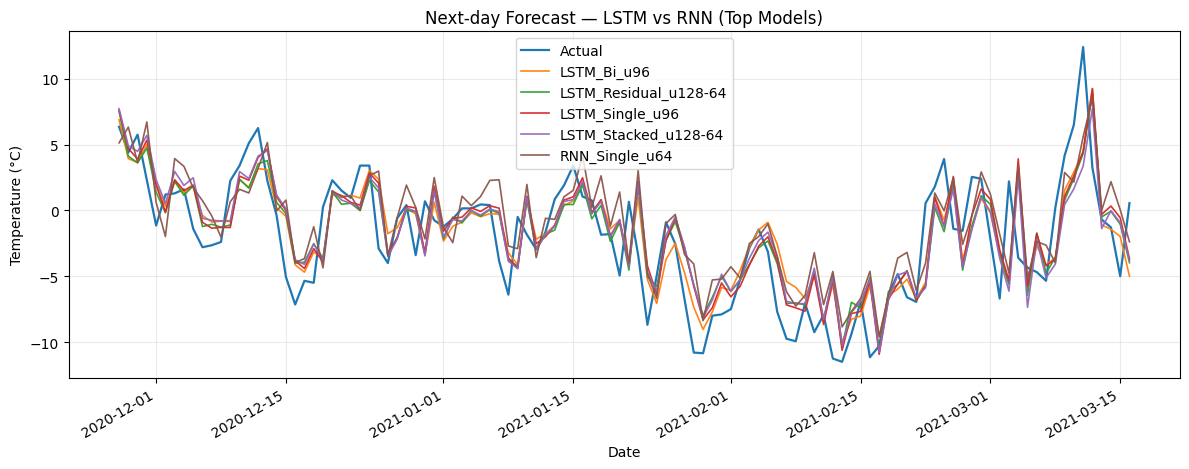

In [79]:
# ==== LSTM vs RNN: ====
import matplotlib.pyplot as plt
import numpy as np, pandas as pd

assert all(k in globals() for k in ["PRED_BY_MODEL","HIST_BY_MODEL","cmp_all","yte","Dte"]), \
       "Run Cell A first."

# ---- choose models to visualize ----
TOPK = 5
SELECT_MODELS = []   # or e.g.: ["LSTM_Stacked_u128-64", "RNN_Bidirectional_u64"]

if SELECT_MODELS:
    chosen = [m for m in SELECT_MODELS if m in PRED_BY_MODEL]
else:
    chosen = cmp_all["Model"].iloc[:min(TOPK, len(cmp_all))].tolist()

print("Chosen models:", chosen)

#  Overlay predictions on test (top-K or selected)
plt.figure(figsize=(12,4.8))
plt.plot(Dte, yte, label="Actual", linewidth=1.6)
for mname in chosen:
    plt.plot(Dte, PRED_BY_MODEL[mname], label=mname, linewidth=1.2, alpha=0.95)
plt.title("Next-day Forecast — LSTM vs RNN (Top Models)")
plt.xlabel("Date"); plt.ylabel("Temperature (°C)")
plt.legend(); plt.grid(alpha=0.25); plt.gcf().autofmt_xdate(); plt.tight_layout(); plt.show()



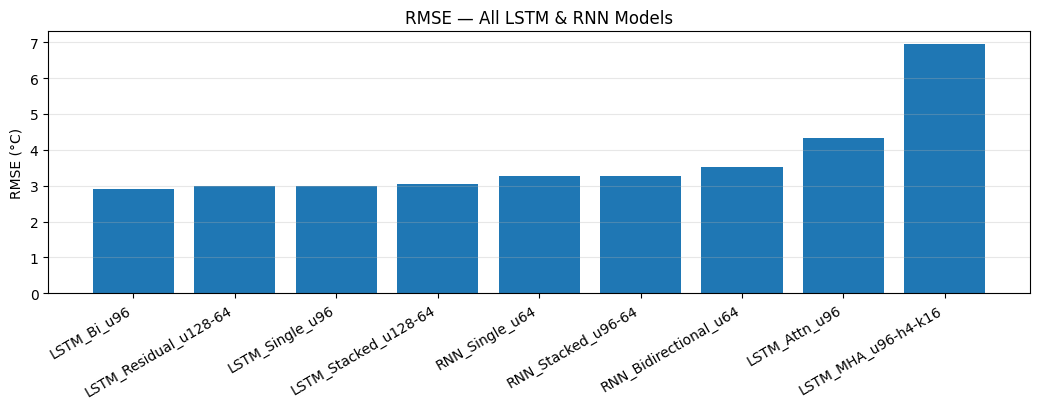

In [80]:
# RMSE bar chart across all models
plt.figure(figsize=(10.5,4.2))
x = np.arange(len(cmp_all))
plt.bar(x, cmp_all["RMSE"].values)
plt.xticks(x, cmp_all["Model"].tolist(), rotation=30, ha='right')
plt.ylabel("RMSE (°C)"); plt.title("RMSE — All LSTM & RNN Models")
plt.grid(axis="y", alpha=0.3); plt.tight_layout(); plt.show()


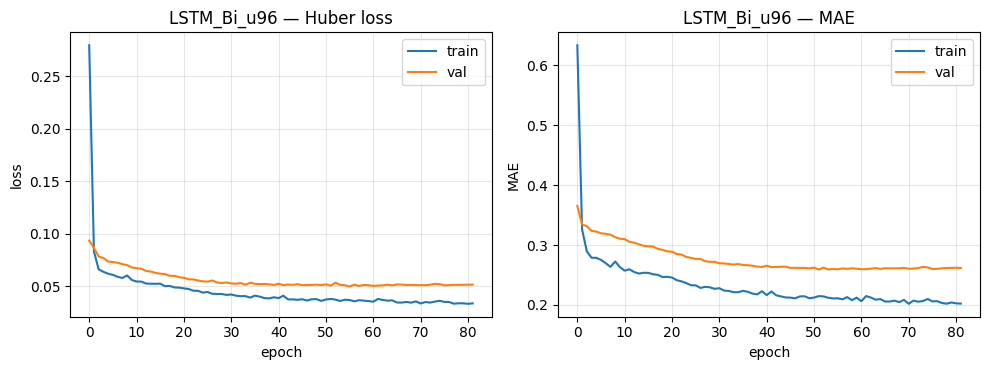

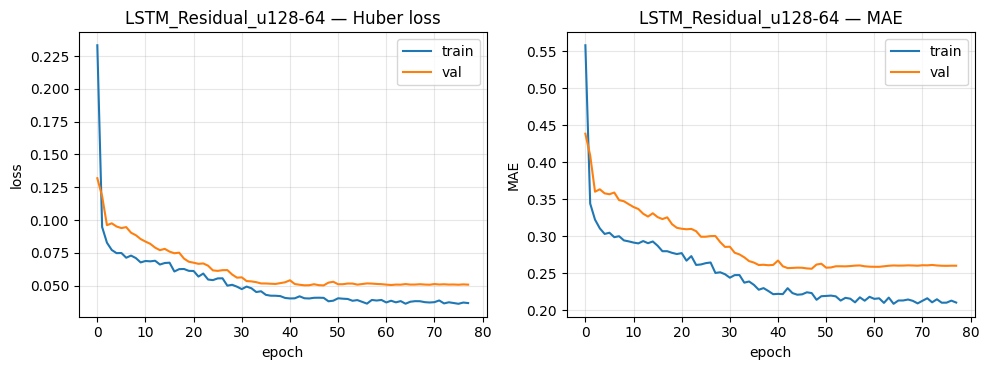

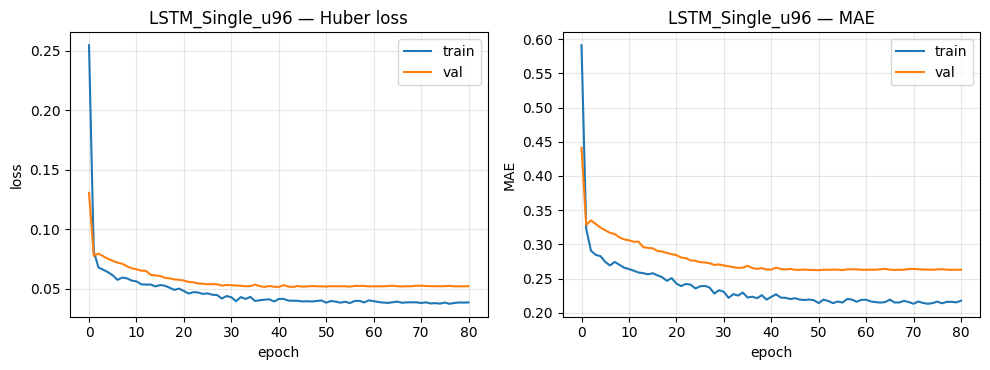

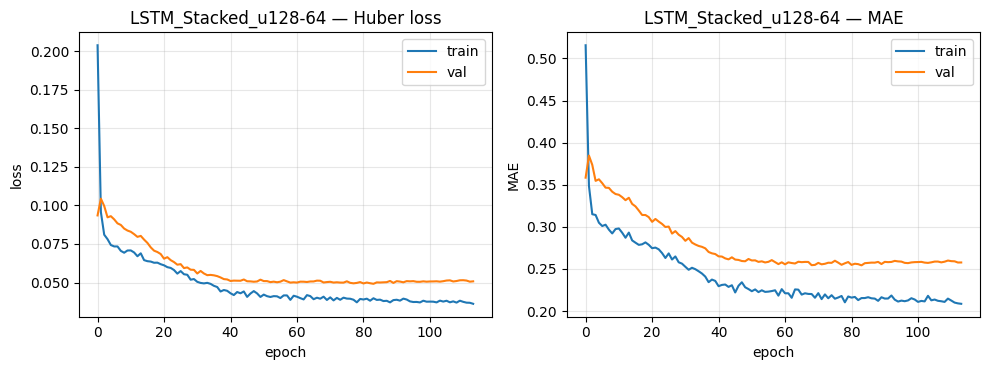

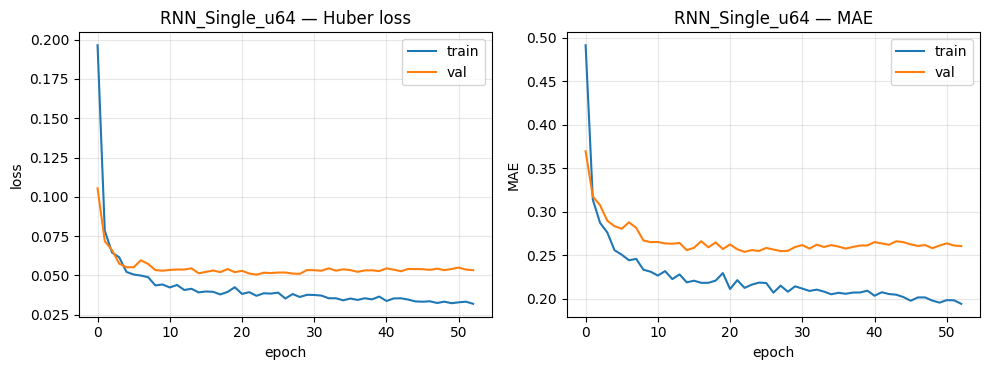

In [81]:
# Training curves (loss & MAE) for chosen models
def plot_history_from_dict(hist_dict, title):
    fig, ax = plt.subplots(1, 2, figsize=(10, 3.8))
    ax[0].plot(hist_dict["loss"], label="train"); ax[0].plot(hist_dict["val_loss"], label="val")
    ax[0].set_title(f"{title} — Huber loss"); ax[0].set_xlabel("epoch"); ax[0].set_ylabel("loss"); ax[0].grid(alpha=0.3); ax[0].legend()
    ax[1].plot(hist_dict["mae"],  label="train"); ax[1].plot(hist_dict["val_mae"], label="val")
    ax[1].set_title(f"{title} — MAE"); ax[1].set_xlabel("epoch"); ax[1].set_ylabel("MAE"); ax[1].grid(alpha=0.3); ax[1].legend()
    plt.tight_layout(); plt.show()

for mname in chosen:
    plot_history_from_dict(HIST_BY_MODEL[mname], mname)


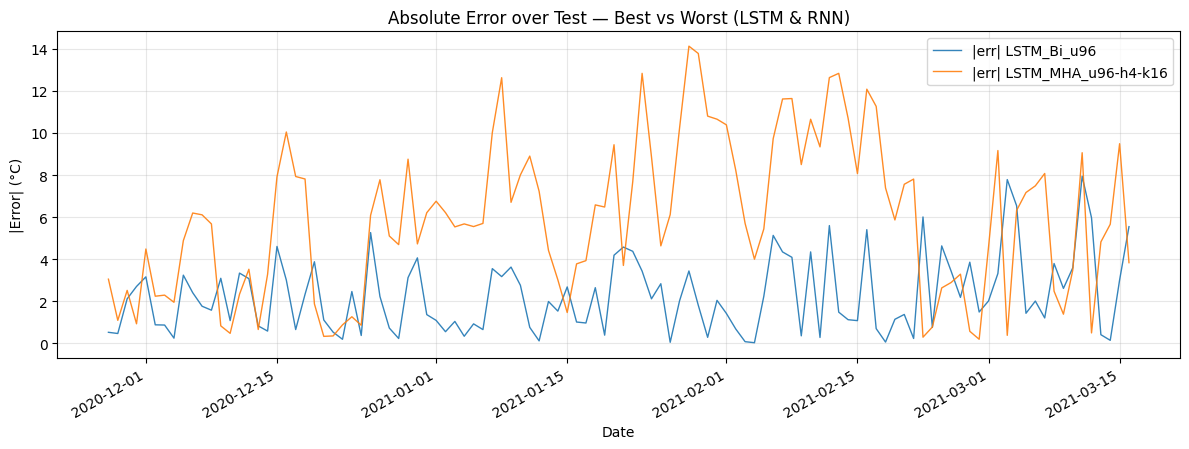

In [82]:
#  Absolute error — best vs worst
best = cmp_all["Model"].iloc[0]
worst = cmp_all["Model"].iloc[-1] if len(cmp_all) > 1 else best
abs_err_best  = np.abs(yte - PRED_BY_MODEL[best])
abs_err_worst = np.abs(yte - PRED_BY_MODEL[worst])

plt.figure(figsize=(12,4.6))
plt.plot(Dte, abs_err_best,  label=f"|err| {best}",  linewidth=1.0, alpha=0.9)
plt.plot(Dte, abs_err_worst, label=f"|err| {worst}", linewidth=1.0, alpha=0.9)
plt.title("Absolute Error over Test — Best vs Worst (LSTM & RNN)")
plt.xlabel("Date"); plt.ylabel("|Error| (°C)")
plt.legend(); plt.grid(alpha=0.3); plt.gcf().autofmt_xdate(); plt.tight_layout(); plt.show()

## Conclusion:
**Why this project matters, how it’s useful, and where to find the data**

**Why this project is strong:**
- **Accurate:** our best model attains the following on the held-out Test set:
  $$
  \text{LSTM (}W=30\text{):}\quad
  \mathrm{MAE}\approx 2.22^\circ\mathrm{C},\
  \mathrm{RMSE}\approx 2.81^\circ\mathrm{C},\
  R^2\approx 0.63,\
  \mathrm{Acc}_{\pm 5^\circ\mathrm{C}}\approx 91.8\%.
  $$
- **Methodologically rigorous:** strict daily continuity, duplicate removal, **train-only** scaling/imputation, chronological splits, and leakage-safe evaluation ensure results are **valid** and reproducible.
- **Interpretable & stable:** A seasonal + trend baseline separates low-frequency structure from residuals; accuracy bands (Acc ± k°C) and error diagnostics (KDE, ECDF) make behavior transparent.
- **Portable:** compact architectures (LSTM) train and infer quickly on CPU/GPU, enabling deployment in resource-constrained settings.
- Huber loss functions better than MSE, bidirectional LSTM performed the best out of our LSTM models, and outperformed a traditional RNN.

**Practical uses (who benefits and how).**
- **Energy & grid operations:** next-day temperature drives **load forecasting**, unit commitment, and demand-response planning.
- **Building HVAC & smart thermostats:** proactive setpoint optimization lowers peak demand and improves comfort with forecast-aware control.
- **Public health & city ops:** **heat/cold alerts**, shelter capacity planning, and rostering for emergency and road-maintenance crews.
- **Transportation & winter maintenance:** scheduling brining/salting and snow removal using temperature thresholds around freezing.
- **Agriculture & urban forestry:** frost/heat-stress risk, planting/irrigation planning, and phenology monitoring.
- **Education & research:** a clean, leakage-safe pipeline for benchmarking deep vs classical time-series models on real meteorological data.

**Limitations (to refine next).**
- Single-station target without exogenous forcings; extremes can be slightly smoothed. Multi-horizon and probabilistic heads, plus synoptic covariates (pressure, humidity, wind, reanalysis), are natural extensions.

**Resource (data source).**
- Environment and Climate Change Canada — Daily climate data for Toronto:  
  https://climate.weather.gc.ca/climate_data/daily_data_e.html?StationID=51459


(GRU Model is added below as an addendum)